In [1]:
#Imports
import pandas as pd
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, RANSACRegressor
from sklearn.model_selection import cross_val_score, KFold, train_test_split, StratifiedKFold, ShuffleSplit, GridSearchCV
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.dates as mdates
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
import xgboost as xgb
from PIL import Image, ImageOps
from PIL import ImageOps

In [2]:
df = pd.read_csv("NBA Champion RawData.csv")
df.head(2)

Season           Team/Season             Team  Team ID Team ID/Season  \
0    2023  Milwaukee Bucks 2023  Milwaukee Bucks        3         3 2023   
1    2023   Boston Celtics 2023   Boston Celtics        6         6 2023   

  Conference Conference/Season  Conference 5=> rec  Conference OR  \
0       East         East 2023            0.492699       0.509465   
1       East         East 2023            0.492699       0.509465   

   Conference SRS  ...   3PAr    TS%  Offense Four Factors|eFG%  \
0        0.464667  ...  0.446  0.583                      0.555   
1        0.464667  ...  0.478  0.600                      0.565   

   Offense Four Factors|TOV%  Offense Four Factors|ORB%  \
0                       12.7                       25.1   
1                       11.9                       22.0   

   Offense Four Factors|FT/FGA  Defense Four Factors|eFG%  \
0                        0.184                      0.520   
1                        0.198                      0.528   

   Defense Four Factors|TOV%  Defense Four Factors|DRB%  \
0                       10.4                       77.7   
1                       11.4                       78.7   

   Defense Four Factors|FT/FGA  
0                        0.175  
1                        0.180  

[2 rows x 116 columns]

In [3]:
df = pd.read_csv("NBA Champion RawData.csv")

exclude_columns = ['Season','Team/Season','Team','Team ID','Team ID/Season','Conference','Conference/Season','make playoffs','champion share','pre playoff odds rank',
                  'champion','top 3 conference','rk conference','curr/past mvp or past fmvp']

reverse_rank_columns = ['pre season odds', 'DRtg']

for col in df.columns:
    if col not in exclude_columns:
        if col in reverse_rank_columns:
            df[col] = df.groupby('Season')[col].rank(method='min', ascending=True)
        else:
            df[col] = df.groupby('Season')[col].rank(method='min', ascending=False)

df.to_csv("NBA Champion LR Data.csv", index=False)

print("NBA Champion LR Data.csv'")

NBA Champion LR Data.csv'


In [4]:
df = pd.read_csv("NBA Champion LR Data.csv")
print(list(df.columns))

['Season', 'Team/Season', 'Team', 'Team ID', 'Team ID/Season', 'Conference', 'Conference/Season', 'Conference 5=> rec', 'Conference OR', 'Conference SRS', 'Conference Age', 'pre playoff odds', 'pre playoff odds rank', 'pre season odds', 'champion', 'champion share', 'make playoffs', 'top 3 conference', 'rk conference', 'overall record', 'over500 rec', 'over600 rec', '20 =< wins', '5 => rec', 'sum coach playoff games', 'sum coy shares', 'sum playoff games', 'sum champion', 'sum champion share', 'sum mvp shares', 'sum all defense', 'sum all nba', 'sum dpoy shares', 'sum smoy shares', 'sum mip shares', 'sum all stars', 'sum player L1Y cs', 'sum player L3Y cs', 'sum player L5Y cs', 'sum player L8Y cs', 'sum player L10Y cs', 'sum L3Y mvp shares ', 'sum L5Y  mvp shares', 'sum franchise L1Y cs', 'sum franchise L3Y cs', 'sum franchise L5Y cs', 'sum franchise L8Y cs', 'sum franchise L10Y cs', 'team_rating_custom', 'max_player_rating_custom', 'curr/past mvp or past fmvp', 'FG', 'FGA', 'FG%', '3P

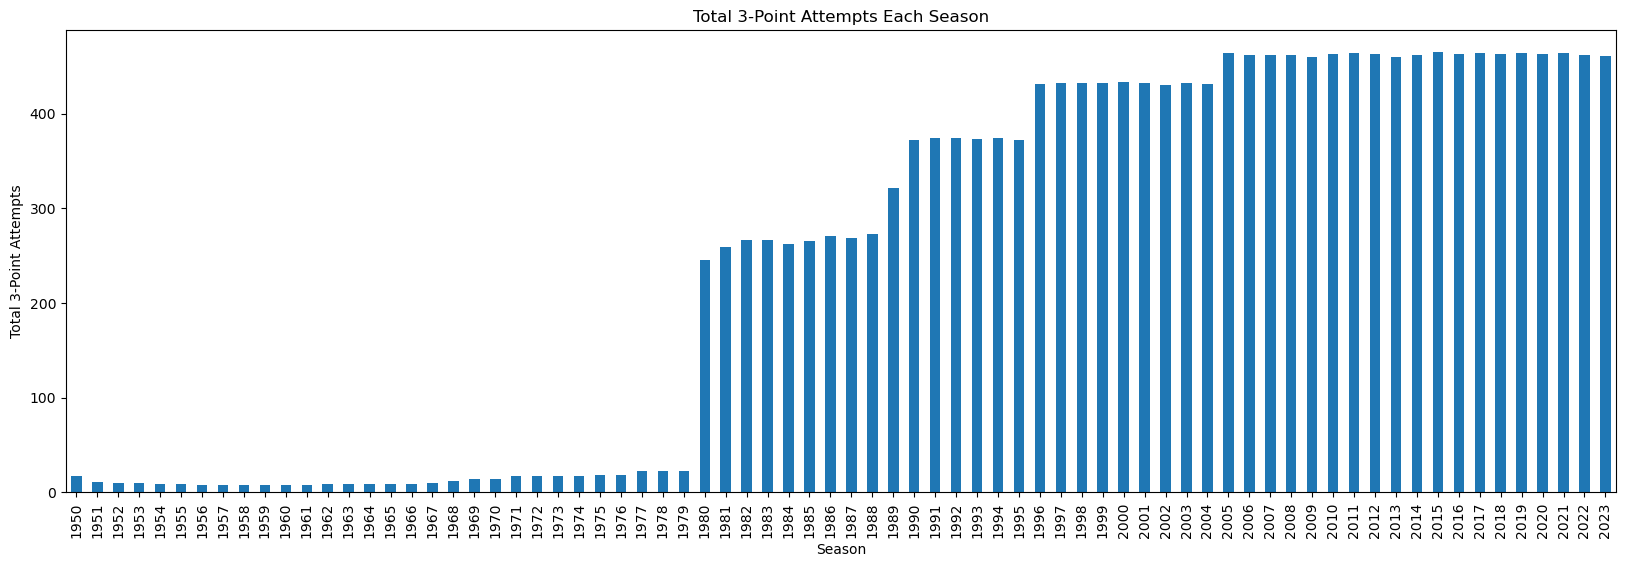

In [5]:
three_point_attempts_per_season = df.groupby('Season')['3PA'].sum()

plt.figure(figsize=(20, 6))

three_point_attempts_per_season.plot(kind='bar', xlabel='Season', ylabel='Total 3-Point Attempts', title='Total 3-Point Attempts Each Season')
plt.show()

## Analyzing Champions Only in the 3-Point Era | 1980 and up

In [6]:
df.drop(df[df['Season'] < 1980].index, inplace = True)
df

Season                 Team/Season                   Team  Team ID  \
0       2023        Milwaukee Bucks 2023        Milwaukee Bucks        3   
1       2023         Boston Celtics 2023         Boston Celtics        6   
2       2023     Philadelphia 76ers 2023     Philadelphia 76ers        2   
3       2023         Denver Nuggets 2023         Denver Nuggets        1   
4       2023      Memphis Grizzlies 2023      Memphis Grizzlies        7   
...      ...                         ...                    ...      ...   
1219    1980         Denver Nuggets 1980         Denver Nuggets        1   
1220    1980          Chicago Bulls 1980          Chicago Bulls        9   
1221    1980              Utah Jazz 1980              Utah Jazz       20   
1222    1980  Golden State Warriors 1980  Golden State Warriors        8   
1223    1980        Detroit Pistons 1980        Detroit Pistons       28   

     Team ID/Season Conference Conference/Season  Conference 5=> rec  \
0            3 2023       East         East 2023                16.0   
1            6 2023       East         East 2023                16.0   
2            2 2023       East         East 2023                16.0   
3            1 2023       West         West 2023                 1.0   
4            7 2023       West         West 2023                 1.0   
...             ...        ...               ...                 ...   
1219         1 1980       West         West 1980                12.0   
1220         9 1980       West         West 1980                12.0   
1221        20 1980       West         West 1980                12.0   
1222         8 1980       West         West 1980                12.0   
1223        28 1980       East         East 1980                 1.0   

      Conference OR  Conference SRS  ...  3PAr   TS%  \
0               1.0             1.0  ...   4.0  15.0   
1               1.0             1.0  ...   2.0   5.0   
2               1.0             1.0  ...  12.0   2.0   
3              16.0            16.0  ...  21.0   3.0   
4              16.0            16.0  ...  16.0  23.0   
...             ...             ...  ...   ...   ...   
1219           12.0            12.0  ...   8.0  21.0   
1220           12.0            12.0  ...   5.0   6.0   
1221           12.0            12.0  ...  11.0   5.0   
1222           12.0            12.0  ...  18.0  16.0   
1223            1.0             1.0  ...  10.0  11.0   

      Offense Four Factors|eFG%  Offense Four Factors|TOV%  \
0                          10.0                       14.0   
1                           5.0                       23.0   
2                           7.0                       15.0   
3                           1.0                        7.0   
4                          20.0                       25.0   
...                         ...                        ...   
1219                       19.0                       15.0   
1220                        9.0                        1.0   
1221                        4.0                        4.0   
1222                       11.0                       10.0   
1223                       12.0                        3.0   

      Offense Four Factors|ORB%  Offense Four Factors|FT/FGA  \
0                           8.0                         28.0   
1                          25.0                         23.0   
2                          27.0                          1.0   
3                          13.0                         24.0   
4                           6.0                         27.0   
...                         ...                          ...   
1219                       10.0                          8.0   
1220                       16.0                          1.0   
1221                       22.0                         10.0   
1222                       19.0                         22.0   
1223                       15.0                         20.0   

      Defense Four Factors|eFG%  Defense 

In [74]:
print(list(df.columns))

['Season', 'Team/Season', 'Team', 'Team ID', 'Team ID/Season', 'Conference', 'Conference/Season', 'Conference 5=> rec', 'pre playoff odds', 'pre playoff odds rank', 'pre season odds', 'champion', 'champion share', 'make playoffs', 'top 3 conference', 'rk conference', 'overall record', 'over500 rec', 'over600 rec', '20 =< wins', '5 => rec', 'sum coach playoff games', 'sum coy shares', 'sum playoff games', 'sum champion', 'sum champion share', 'sum mvp shares', 'sum all defense', 'sum all nba', 'sum dpoy shares', 'sum smoy shares', 'sum mip shares', 'sum all stars', 'sum player L1Y cs', 'sum player L3Y cs', 'sum player L5Y cs', 'sum player L8Y cs', 'sum player L10Y cs', 'sum L3Y mvp shares ', 'sum L5Y  mvp shares', 'sum franchise L1Y cs', 'sum franchise L3Y cs', 'sum franchise L5Y cs', 'sum franchise L8Y cs', 'sum franchise L10Y cs', 'team_rating_custom', 'max_player_rating_custom', 'curr/past mvp or past fmvp', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT

In [5]:
data_columns = ['Conference 5=> rec', 'pre playoff odds rank', 'pre season odds', 'champion share','top 3 conference', 'rk conference',
                'overall record', 'over500 rec', 'over600 rec', '20 =< wins', '5 => rec', 'sum coach playoff games', 'sum coy shares', 'sum playoff games', 'sum champion', 'sum champion share', 
                'sum mvp shares', 'sum all defense', 'sum all nba', 'sum dpoy shares', 'sum smoy shares', 'sum mip shares', 'sum all stars', 'sum player L1Y cs', 'sum player L3Y cs', 
                'sum player L5Y cs', 'sum player L8Y cs', 'sum player L10Y cs', 'sum L3Y mvp shares ', 'sum L5Y  mvp shares', 'sum franchise L1Y cs', 'sum franchise L3Y cs',
                'sum franchise L5Y cs', 'sum franchise L8Y cs', 'sum franchise L10Y cs', 'team_rating_custom', 'max_player_rating_custom', 'curr/past mvp or past fmvp', 
                'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'FG_opp', 
                'FGA_opp', 'FG%_opp', '3P_opp', '3PA_opp', '3P%_opp', '2P_opp', '2PA_opp', '2P%_opp', 'FT_opp', 'FTA_opp', 'FT%_opp', 'ORB_opp', 'DRB_opp', 'TRB_opp',
                'AST_opp', 'STL_opp', 'BLK_opp', 'TOV_opp', 'PF_opp', 'PTS_opp', 'Age', 'W', 'L', 'PW', 'PL', 'MOV', 'SOS', 'SRS', 'ORtg', 'DRtg', 'NRtg', 'Pace', 
                'FTr', '3PAr', 'TS%', 'Offense Four Factors|eFG%', 'Offense Four Factors|TOV%', 'Offense Four Factors|ORB%', 'Offense Four Factors|FT/FGA',
                'Defense Four Factors|eFG%', 'Defense Four Factors|TOV%', 'Defense Four Factors|DRB%', 'Defense Four Factors|FT/FGA']

df= df.dropna(subset=data_columns)
data = df[data_columns].copy()

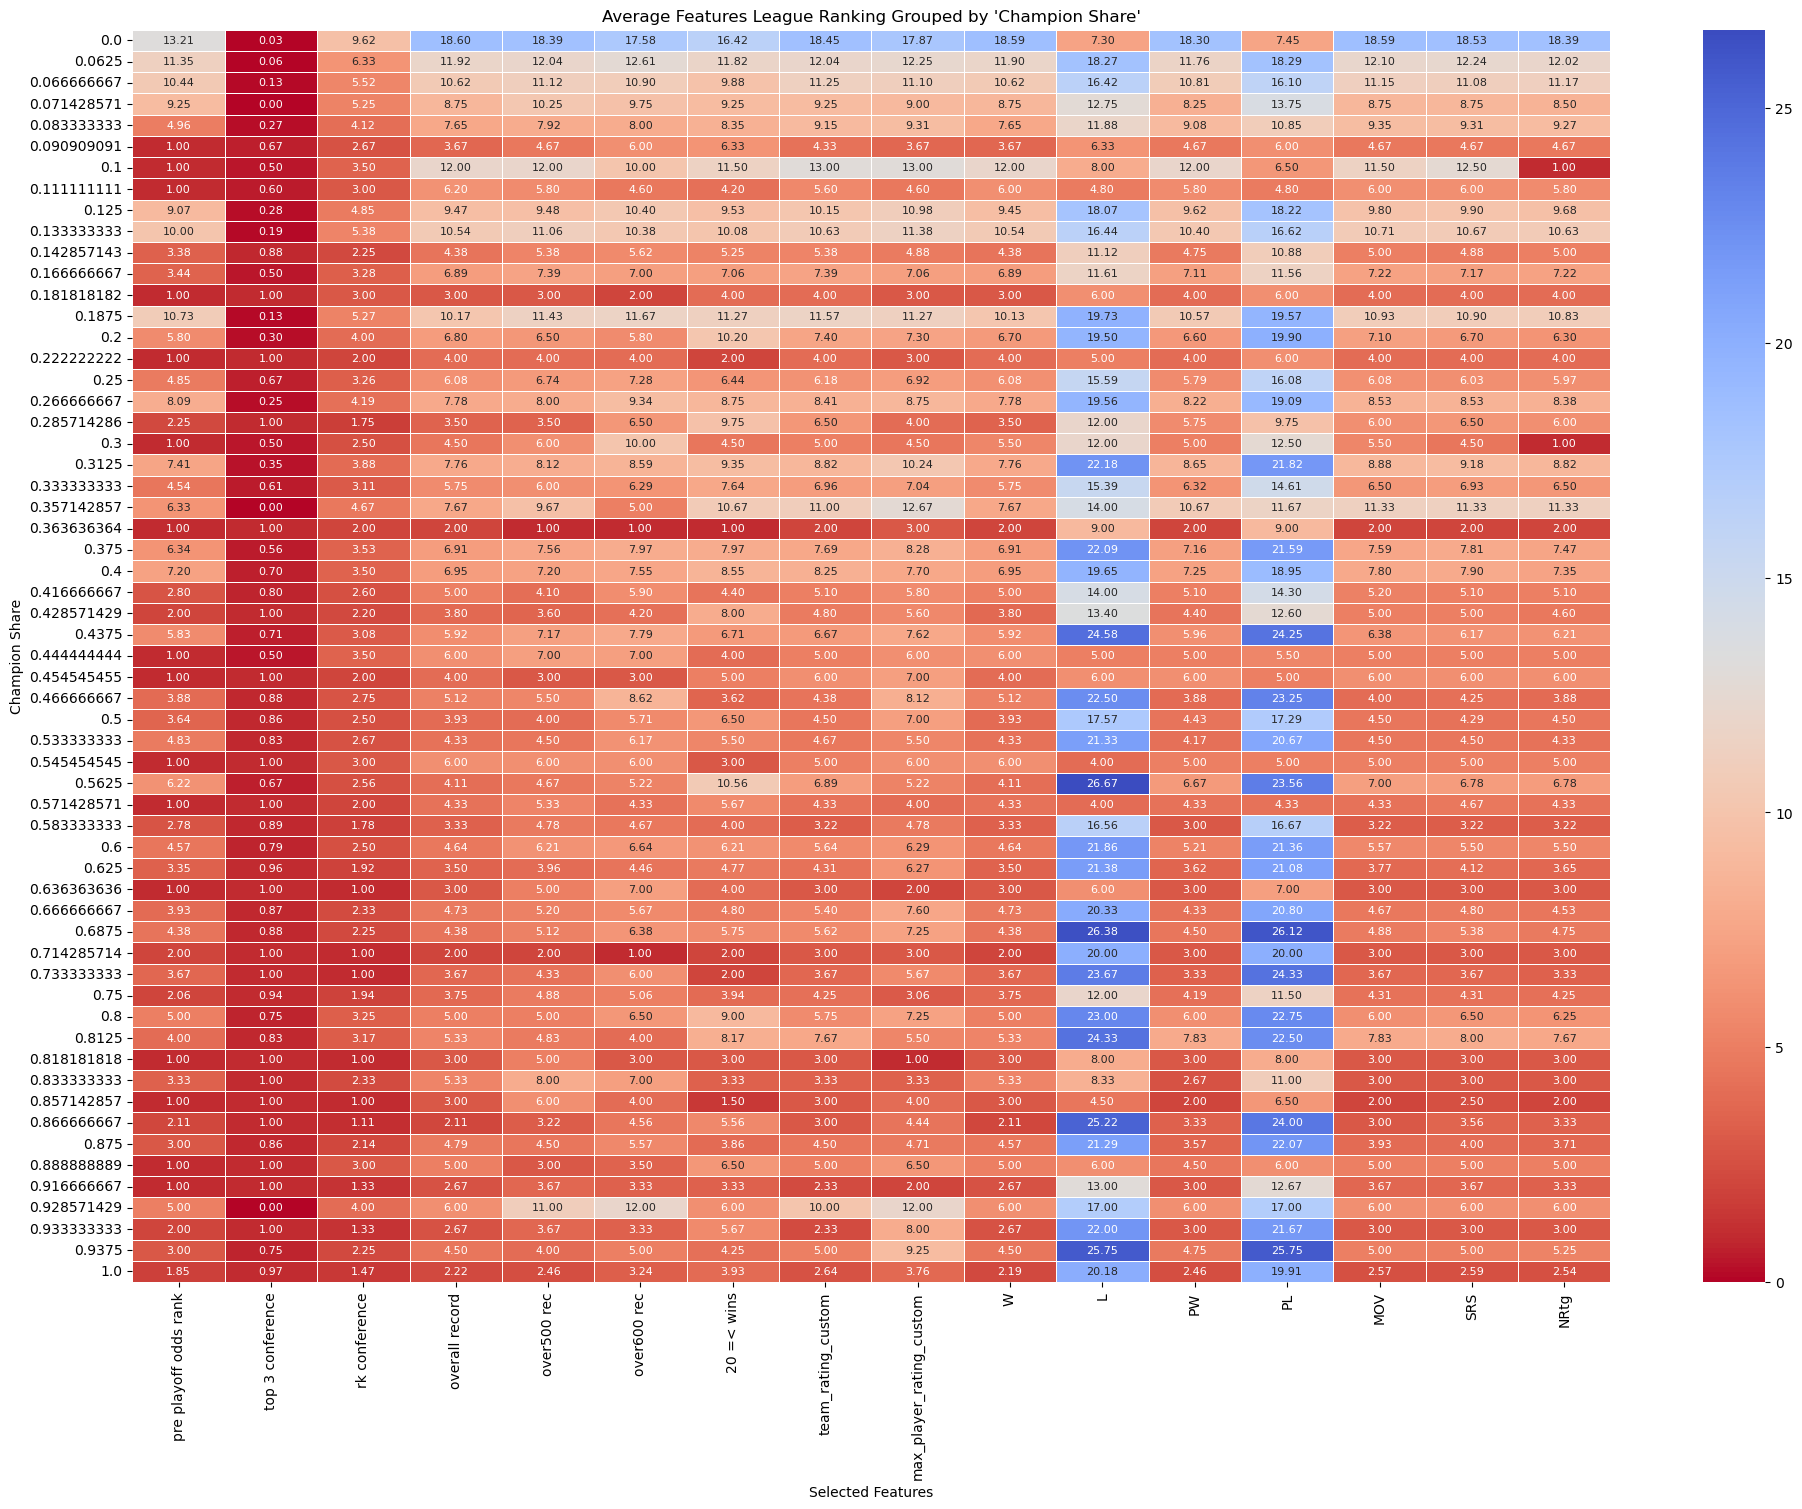

In [6]:
corr = data.corr().abs()
selected_features = corr.loc[corr['champion share']>.5].index

corr_df = data[selected_features].groupby('champion share').mean()

plt.rcParams['figure.figsize'] = (20, 15)
plt.title("Average Features League Ranking Grouped by 'Champion Share'")
sns.heatmap(data=corr_df, cmap='coolwarm_r', annot=True, linewidth=.5, annot_kws={"size": 8}, fmt=".2f")

plt.xticks(rotation=90)  
plt.yticks(rotation=0)   

plt.tight_layout()  

plt.xlabel("Selected Features")
plt.ylabel("Champion Share")

plt.savefig("avg_fea_ht.png", bbox_inches='tight', pad_inches=0.1)
image = Image.open("avg_fea_ht.png")
image_with_border = ImageOps.expand(image, border=2, fill='black')
image_with_border.save("avg_fea_ht.png")
plt.show()

### Analysis of Wins to Playoff Rounds | 1980:
#### Champions:
- On average championship teams ranked top 3 in league in wins, 60 wins (bit closer to top 2)
- The bare minimum in LR of win % is 10th (47 wins) in the NBA, only been done once (1995 Houston Rockets).
- 93.18% of all nba champions since 1980 are a top 5 team in the league in wins.
#### Finals:
- On average finals teams ranked top 3 in league in wins, 54 wins
- The bare minimum in LR of win % is 13th (40 wins) in the NBA (1999 New York Knicks)
- 93.18% of all finalists since 1980 are a top 5 team in the league in wins.
#### Conference Finals:
- On average cf teams ranked top 4 in league in wins, 57 wins
- The bare minimum in LR of win % is 14th (42 wins) in the NBA (2023 LA Lakers)
- 93.18% of all cfs since 1980 are a top 5 team in the league in wins.

In [78]:

df = pd.read_csv("NBA Champion LR Data.csv")
df.drop(df[df['Season'] < 1980].index, inplace = True)

filtered_df = df[df['champion share'] >= .50]

selected_columns_df = filtered_df[['Season', 'Team', 'champion share', 'overall record']]
sorted_df = selected_columns_df.sort_values(by='overall record', ascending=False)
print(sorted_df)

print("====================================================================================\n")

df = pd.read_csv("NBA Champion RawData.csv")
df.drop(df[df['Season'] < 1980].index, inplace = True)

filtered_df = df[df['champion share'] >= .50]

selected_columns_df = filtered_df[['Season', 'Team', 'champion share', 'overall record']]
sorted_df = selected_columns_df.sort_values(by='overall record', ascending=True)
print(sorted_df)

      Season                   Team  champion share  overall record
13      2023     Los Angeles Lakers          0.5000            14.0
727     1999        New York Knicks          0.8000            13.0
1121    1984           Phoenix Suns          0.6000            12.0
10      2023             Miami Heat          0.8125            11.0
1190    1981        Houston Rockets          0.8750            11.0
...      ...                    ...             ...             ...
180     2017  Golden State Warriors          1.0000             1.0
1018    1988     Los Angeles Lakers          1.0000             1.0
686     2000     Los Angeles Lakers          1.0000             1.0
1041    1987     Los Angeles Lakers          1.0000             1.0
240     2015  Golden State Warriors          1.0000             1.0

[165 rows x 4 columns]

      Season                   Team  champion share  overall record
1190    1981        Houston Rockets        0.875000        0.487805
1189    1981      Kansa

In [37]:
df = pd.read_csv("NBA Champion LR Data.csv")
#df = pd.read_csv("NBA Champion RawData.csv")
#print(list(df.columns))
df.drop(df[df['Season'] < 1980].index, inplace = True)

champion = df.loc[df['champion share'] >= 0.50]
champion_misc_stats = champion['overall record'].describe()

print("Summary Statistics for Champions' Rk in W%:")
print(champion_misc_stats)

Summary Statistics for Champions' Rk in W%:
count    165.000000
mean       3.769697
std        2.844816
min        1.000000
25%        2.000000
50%        3.000000
75%        5.000000
max       14.000000
Name: overall record, dtype: float64


In [38]:
#df = pd.read_csv("NBA Champion LR Data.csv")
df = pd.read_csv("NBA Champion RawData.csv")
#print(list(df.columns))
df.drop(df[df['Season'] < 1980].index, inplace = True)

champion = df.loc[df['champion share'] >= 0.50]
champion_misc_stats = champion['overall record'].describe()

print("Summary Statistics for Champions' W%:")
print(champion_misc_stats)

Summary Statistics for Champions' W%:
count    165.000000
mean       0.692957
std        0.071031
min        0.487805
25%        0.646341
50%        0.695122
75%        0.740000
max        0.890244
Name: overall record, dtype: float64


In [40]:
df = pd.read_csv("NBA Champion LR Data.csv")
#df = pd.read_csv("NBA Champion RawData.csv")
df.drop(df[df['Season'] < 1980].index, inplace = True)


champions_df = df[df['champion'] >= .50]
unique_ranks = champions_df['overall record'].unique()
percentage_results = {}

for rank in unique_ranks:
    champions_with_rank = champions_df[champions_df['overall record'] == rank]
    total_champions = champions_df.shape[0]
    percentage = (champions_with_rank.shape[0] / total_champions) * 100
    percentage_results[f'Rank {rank}'] = percentage

sorted_results = sorted(percentage_results.items(), key=lambda x: x[1], reverse=True)

for rank, percentage in sorted_results:
    print(f"The percentage of champions W% rank {rank}: {percentage:.2f}%")

The percentage of champions W% rank Rank 1.0: 43.18%
The percentage of champions W% rank Rank 2.0: 22.73%
The percentage of champions W% rank Rank 3.0: 18.18%
The percentage of champions W% rank Rank 4.0: 6.82%
The percentage of champions W% rank Rank 7.0: 2.27%
The percentage of champions W% rank Rank 5.0: 2.27%
The percentage of champions W% rank Rank 6.0: 2.27%
The percentage of champions W% rank Rank 10.0: 2.27%


In [41]:
43.18+22.73+18.18+6.82+2.27

93.17999999999999

In [15]:
#df = pd.read_csv("NBA Champion LR Data.csv")
df = pd.read_csv("NBA Champion RawData.csv")
#print(list(df.columns))
df.drop(df[df['Season'] < 1980].index, inplace = True)

champion = df.loc[df['champion share'] == 1.00]
champion_misc_stats = champion['overall record'].describe()

print("Summary Statistics for Champions' W%:")
print(champion_misc_stats)

Summary Statistics for Champions' W%:
count    44.000000
mean      0.736397
std       0.063508
min       0.573171
25%       0.695122
50%       0.732051
75%       0.792683
max       0.878049
Name: overall record, dtype: float64


In [8]:
df = pd.read_csv("NBA Champion LR Data.csv")
print(list(df.columns))

['Season', 'Team/Season', 'Team', 'Team ID', 'Team ID/Season', 'Conference', 'Conference/Season', 'Conference 5=> rec', 'Conference OR', 'Conference SRS', 'Conference Age', 'pre playoff odds', 'pre playoff odds rank', 'pre season odds', 'champion', 'champion share', 'make playoffs', 'top 3 conference', 'rk conference', 'overall record', 'over500 rec', 'over600 rec', '20 =< wins', '5 => rec', 'sum coach playoff games', 'sum coy shares', 'sum playoff games', 'sum champion', 'sum champion share', 'sum mvp shares', 'sum all defense', 'sum all nba', 'sum dpoy shares', 'sum smoy shares', 'sum mip shares', 'sum all stars', 'sum player L1Y cs', 'sum player L3Y cs', 'sum player L5Y cs', 'sum player L8Y cs', 'sum player L10Y cs', 'sum L3Y mvp shares ', 'sum L5Y  mvp shares', 'sum franchise L1Y cs', 'sum franchise L3Y cs', 'sum franchise L5Y cs', 'sum franchise L8Y cs', 'sum franchise L10Y cs', 'team_rating_custom', 'max_player_rating_custom', 'curr/past mvp or past fmvp', 'FG', 'FGA', 'FG%', '3P

### Bracketology

In [20]:
df = pd.read_csv("NBA Champion LR Data.csv")
#df = pd.read_csv("NBA Champion RawData.csv")
#print(list(df.columns))
df.drop(df[df['Season'] < 1980].index, inplace = True)
df = df[df['make playoffs']==1]

print("Seed")

champions_df = df[df['champion share'] == 1.00]
unique_ranks = champions_df['rk conference'].unique()
percentage_results = {}

for rank in unique_ranks:
    champions_with_rank = champions_df[champions_df['rk conference'] == rank]
    total_champions = champions_df.shape[0]
    percentage = (champions_with_rank.shape[0] / total_champions) * 100
    percentage_results[f'Rank {rank}'] = percentage

sorted_results = sorted(percentage_results.items(), key=lambda x: x[1], reverse=True)

for rank, percentage in sorted_results:
    print(f"The percentage of champions seed {rank}: {percentage:.2f}%")

Seed
The percentage of champions seed Rank 1: 65.91%
The percentage of champions seed Rank 2: 25.00%
The percentage of champions seed Rank 3: 6.82%
The percentage of champions seed Rank 6: 2.27%


Average Champion Share by Rank Conference | Since 1980
rk conference
1    0.700399
2    0.551976
3    0.371780
5    0.239740
4    0.207131
6    0.125833
7    0.112608
8    0.078484
9    0.078125
Name: champion share, dtype: float64


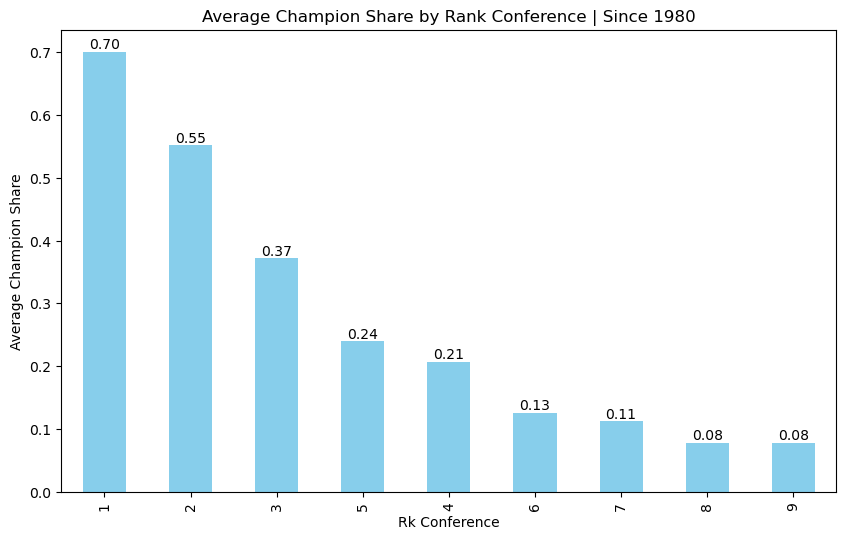

Max Champion Share by Rank Conference| Since 1980
rk conference
1    1.0000
2    1.0000
3    1.0000
6    1.0000
4    0.9375
5    0.8750
7    0.8125
8    0.8000
9    0.1250
Name: champion share, dtype: float64


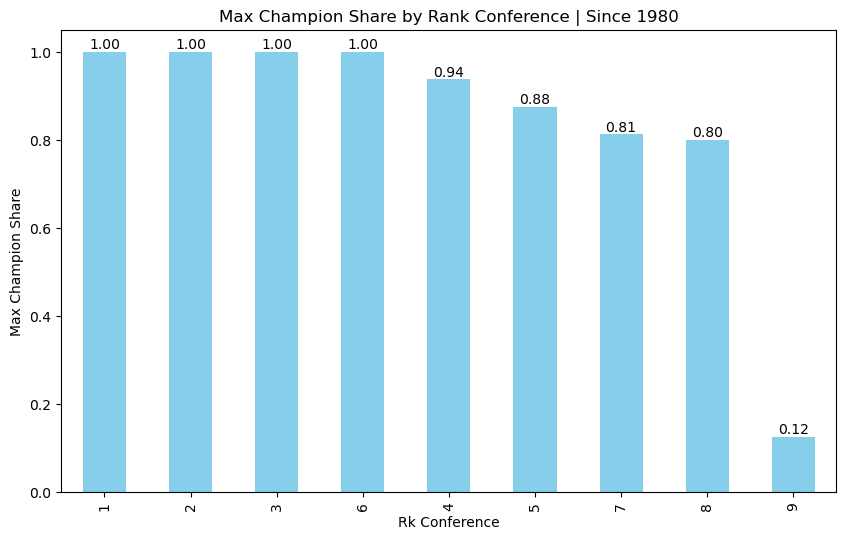

In [22]:
df = pd.read_csv("NBA Champion LR Data.csv")
#df = pd.read_csv("NBA Champion RawData.csv")
#print(list(df.columns))
df.drop(df[df['Season'] < 1980].index, inplace = True)
df = df[df['make playoffs']==1]

#=========================================================================================================================

avg_champion_share = df.groupby('rk conference')['champion share'].mean()
avg_champion_share_sorted = avg_champion_share.sort_values(ascending=False)

print("Average Champion Share by Rank Conference | Since 1980")
print(avg_champion_share_sorted)

fig, ax = plt.subplots(figsize=(10, 6))

ax = avg_champion_share_sorted.plot(kind='bar', color='skyblue')
plt.title('Average Champion Share by Rank Conference | Since 1980')
plt.xlabel('Rk Conference')
plt.ylabel('Average Champion Share')

for i, v in enumerate(avg_champion_share_sorted):
    ax.text(i, v - 0.0,f'{v:.2f}', ha='center', va='bottom')

plt.savefig("avg_cs_seed.png", bbox_inches='tight', pad_inches=0.1)
image = Image.open("avg_cs_seed.png")
image_with_border = ImageOps.expand(image, border=2, fill='black')
image_with_border.save("avg_cs_seed.png")    
    
plt.show()    

#=========================================================================================================================

max_champion_share = df.groupby('rk conference')['champion share'].max()
max_champion_share_sorted = max_champion_share.sort_values(ascending=False)

print("Max Champion Share by Rank Conference| Since 1980")
print(max_champion_share_sorted)

fig, ax = plt.subplots(figsize=(10, 6))

ax = max_champion_share_sorted.plot(kind='bar', color='skyblue')
plt.title('Max Champion Share by Rank Conference | Since 1980')
plt.xlabel('Rk Conference')
plt.ylabel('Max Champion Share')

for i, v in enumerate(max_champion_share_sorted):
    ax.text(i, v - 0.0,f'{v:.2f}', ha='center', va='bottom')
    
plt.savefig("max_cs_seed.png", bbox_inches='tight', pad_inches=0.1)
image = Image.open("max_cs_seed.png")
image_with_border = ImageOps.expand(image, border=2, fill='black')
image_with_border.save("max_cs_seed.png")   

plt.show()

In [9]:
16*.7

11.2

In [24]:
df = pd.read_csv("NBA Champion LR Data.csv")
#df = pd.read_csv("NBA Champion RawData.csv")
#print(list(df.columns))
df.drop(df[df['Season'] < 1980].index, inplace = True)
df = df[df['make playoffs']==1]

#=========================================================================================================================

print("============================= Round of 8 Advance % =====================================\n")

for seed in range(1, 10):
    total_seeds = df[df['rk conference'] == seed] 
    qualified_seeds = total_seeds[total_seeds['champion share'] >= 0.25]  

    count_qualified_seeds = len(qualified_seeds)
    total_seeds_count = len(total_seeds)

    percentage_qualified_seeds = (count_qualified_seeds / total_seeds_count) * 100

    print(f"Percentage of {seed} seeds with champion share >= 0.25: {percentage_qualified_seeds}%")

print("\n")
print("============================= Conference Finals Advance % =====================================\n")

for seed in range(1, 10):
    total_seeds = df[df['rk conference'] == seed]  
    qualified_seeds = total_seeds[total_seeds['champion share'] >= 0.5]  

    count_qualified_seeds = len(qualified_seeds)
    total_seeds_count = len(total_seeds)

    percentage_qualified_seeds = (count_qualified_seeds / total_seeds_count) * 100

    print(f"Percentage of {seed} seeds with champion share >= 0.5: {percentage_qualified_seeds}%")
    
print("\n")
print("============================= Finals Advance % =====================================\n")

for seed in range(1, 10):
    total_seeds = df[df['rk conference'] == seed]  
    qualified_seeds = total_seeds[total_seeds['champion share'] >= 0.75]  

    count_qualified_seeds = len(qualified_seeds)
    total_seeds_count = len(total_seeds)

    percentage_qualified_seeds = (count_qualified_seeds / total_seeds_count) * 100

    print(f"Percentage of {seed} seeds with champion share >= 0.75: {percentage_qualified_seeds}%")
    
print("\n")
print("============================= Champion % =====================================\n")

for seed in range(1, 10):
    total_seeds = df[df['rk conference'] == seed]  
    qualified_seeds = total_seeds[total_seeds['champion share'] >= 1]  

    count_qualified_seeds = len(qualified_seeds)
    total_seeds_count = len(total_seeds)

    percentage_qualified_seeds = (count_qualified_seeds / total_seeds_count) * 100

    print(f"Percentage of {seed} seeds with champion share >= 1.0: {percentage_qualified_seeds}%")

============================= Round of 8 Advance % =====================================

Percentage of 1 seeds with champion share >= 0.25: 92.5531914893617%
Percentage of 2 seeds with champion share >= 0.25: 85.56701030927834%
Percentage of 3 seeds with champion share >= 0.25: 72.72727272727273%
Percentage of 4 seeds with champion share >= 0.25: 41.23711340206185%
Percentage of 5 seeds with champion share >= 0.25: 45.0%
Percentage of 6 seeds with champion share >= 0.25: 16.666666666666664%
Percentage of 7 seeds with champion share >= 0.25: 10.38961038961039%
Percentage of 8 seeds with champion share >= 0.25: 4.918032786885246%
Percentage of 9 seeds with champion share >= 0.25: 0.0%


============================= Conference Finals Advance % =====================================

Percentage of 1 seeds with champion share >= 0.5: 77.6595744680851%
Percentage of 2 seeds with champion share >= 0.5: 52.57731958762887%
Percentage of 3 seeds with champion share >= 0.5: 23.863636363636363%
P

### Offense v. Defense | NBA Champions

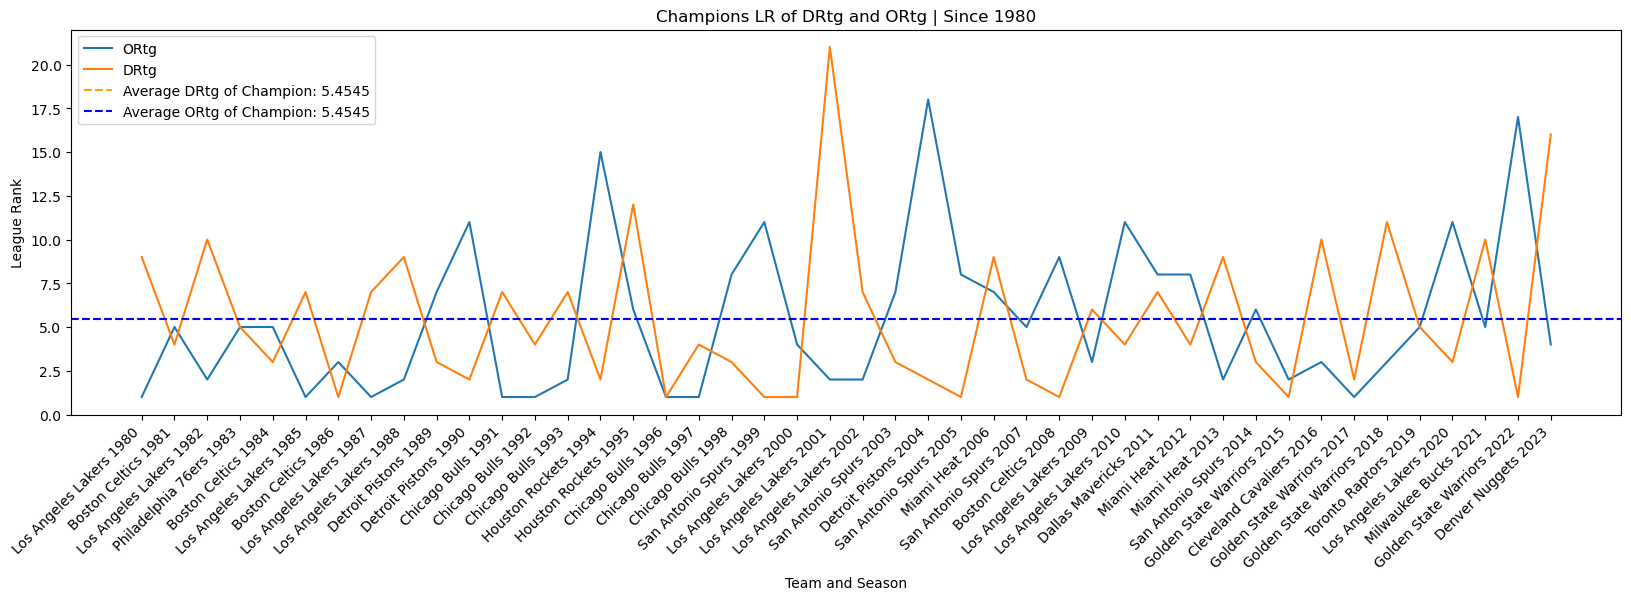

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

df = pd.read_csv("NBA Champion LR Data.csv")
#df = pd.read_csv("NBA Champion RawData.csv")
#print(list(df.columns))
df.drop(df[df['Season'] < 1980].index, inplace = True)


df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
with warnings.catch_warnings():
    warnings.simplefilter('ignore', FutureWarning)

    champion_sea = df.loc[df['champion share'] == 1].copy() 

    champion_sea.replace([np.inf, -np.inf], np.nan, inplace=True)

    champion_sea.sort_values(by='Season', inplace=True)

    champion_sea['Season'] = champion_sea['Season'].astype(str)

    plt.figure(figsize=(20, 5))
    plt.title("Champions LR of DRtg and ORtg | Since 1980")
    sns.lineplot(x=champion_sea['Team'] + ' ' + champion_sea['Season'], y=champion_sea['ORtg'], label="ORtg")
    sns.lineplot(x=champion_sea['Team'] + ' ' + champion_sea['Season'], y=champion_sea['DRtg'], label="DRtg")

    average_ORtg = champion_sea['ORtg'].mean()
    average_DRtg = champion_sea['DRtg'].mean()

    plt.axhline(y=average_ORtg, color='orange', linestyle='--', label=f'Average DRtg of Champion: {average_DRtg:.4f}')
    plt.axhline(y=average_DRtg, color='blue', linestyle='--', label=f'Average ORtg of Champion: {average_ORtg:.4f}')

    plt.xlabel('Team and Season')
    plt.ylabel('League Rank')

    plt.xticks(rotation=45, ha='right')
    plt.legend() 
    
    #save the fig
    plt.savefig("chp_OvD_Chp.png", bbox_inches='tight', pad_inches=0.1)
    image = Image.open("chp_OvD_Chp.png")
    image_with_border = ImageOps.expand(image, border=2, fill='black')
    image_with_border.save("chp_OvD_Chp.png")
    
    plt.show()

In [26]:
champions_df = df[df['champion'] == 1.00]
unique_ranks = champions_df['ORtg'].unique()
percentage_results = {}

for rank in unique_ranks:
    champions_with_rank = champions_df[champions_df['ORtg'] == rank]
    total_champions = champions_df.shape[0]
    percentage = (champions_with_rank.shape[0] / total_champions) * 100
    percentage_results[f'Rank {rank}'] = percentage

sorted_results = sorted(percentage_results.items(), key=lambda x: x[1], reverse=True)

for rank, percentage in sorted_results:
    print(f"The percentage of champions ORtg rank {rank}: {percentage:.2f}%")
    
#==================================================================================    
print("===========================================================================\n")

champions_df = df[df['champion'] == 1.00]
unique_ranks = champions_df['DRtg'].unique()
percentage_results = {}

for rank in unique_ranks:
    champions_with_rank = champions_df[champions_df['DRtg'] == rank]
    total_champions = champions_df.shape[0]
    percentage = (champions_with_rank.shape[0] / total_champions) * 100
    percentage_results[f'Rank {rank}'] = percentage

sorted_results = sorted(percentage_results.items(), key=lambda x: x[1], reverse=True)

for rank, percentage in sorted_results:
    print(f"The percentage of champions DRtg rank {rank}: {percentage:.2f}%")

The percentage of champions ORtg rank Rank 1.0: 18.18%
The percentage of champions ORtg rank Rank 2.0: 15.91%
The percentage of champions ORtg rank Rank 5.0: 13.64%
The percentage of champions ORtg rank Rank 11.0: 9.09%
The percentage of champions ORtg rank Rank 3.0: 9.09%
The percentage of champions ORtg rank Rank 8.0: 9.09%
The percentage of champions ORtg rank Rank 7.0: 6.82%
The percentage of champions ORtg rank Rank 4.0: 4.55%
The percentage of champions ORtg rank Rank 6.0: 4.55%
The percentage of champions ORtg rank Rank 17.0: 2.27%
The percentage of champions ORtg rank Rank 9.0: 2.27%
The percentage of champions ORtg rank Rank 18.0: 2.27%
The percentage of champions ORtg rank Rank 15.0: 2.27%

The percentage of champions DRtg rank Rank 1.0: 18.18%
The percentage of champions DRtg rank Rank 3.0: 13.64%
The percentage of champions DRtg rank Rank 7.0: 13.64%
The percentage of champions DRtg rank Rank 2.0: 11.36%
The percentage of champions DRtg rank Rank 4.0: 11.36%
The percentage 

In [28]:
df = pd.read_csv("NBA Champion LR Data.csv")
#df = pd.read_csv("NBA Champion RawData.csv")
#print(list(df.columns))
#df.drop(df[df['Season'] < 1980].index, inplace = True)


# List of columns to filter on
selected_columns = ['Season', 'Team', 'ORtg', 'DRtg', 'champion share']

# Filtering rows where 'Champion Share' is equal to 1.00
filtered_df = df[df['champion share'] == 1.00][selected_columns]

# Displaying the resulting DataFrame
print(filtered_df)
filtered_df.to_csv("filtered_data.csv", index=False)

      Season                   Team  ORtg  DRtg  champion share
3       2023         Denver Nuggets   4.0  16.0             1.0
32      2022  Golden State Warriors  17.0   1.0             1.0
66      2021        Milwaukee Bucks   5.0  10.0             1.0
92      2020     Los Angeles Lakers  11.0   3.0             1.0
121     2019        Toronto Raptors   5.0   5.0             1.0
...      ...                    ...   ...   ...             ...
1546    1954     Minneapolis Lakers   5.0   2.0             1.0
1555    1953     Minneapolis Lakers   4.0   1.0             1.0
1566    1952     Minneapolis Lakers   7.0   1.0             1.0
1577    1951       Rochester Royals   1.0   7.0             1.0
1587    1950     Minneapolis Lakers   1.0   1.0             1.0

[74 rows x 5 columns]


In [7]:
18.18+11.36+13.61+11.36+4.55

59.059999999999995

In [8]:
18.18+15.91+9.09+4.55+13.64

61.370000000000005

### SRS | NBA Champions

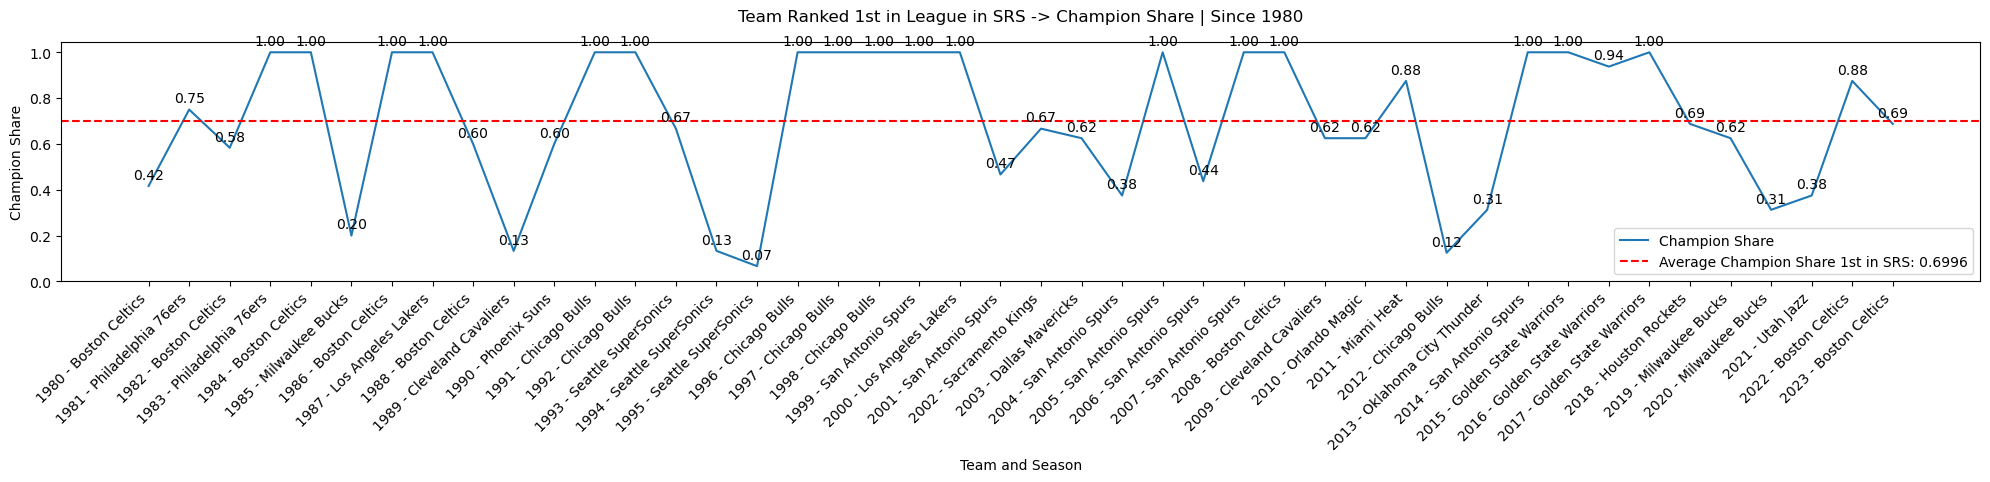

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

df = pd.read_csv("NBA Champion LR Data.csv")
#df = pd.read_csv("NBA Champion RawData.csv")
#print(list(df.columns))
df.drop(df[df['Season'] < 1980].index, inplace = True)


df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
with warnings.catch_warnings():
    warnings.simplefilter('ignore', FutureWarning)

    first_in_league_SRS = df.loc[df['SRS'] == 1].copy()

    first_in_league_SRS .sort_values(by='Season', inplace=True)

    plt.figure(figsize=(20, 5))
    plt.title("Team Ranked 1st in League in SRS -> Champion Share | Since 1980")

    plt.title("Team Ranked 1st in League in SRS -> Champion Share | Since 1980", y=1.05)

    first_in_league_SRS.loc[:, 'Season'] = first_in_league_SRS['Season'].astype(str)

    sns.lineplot(x=first_in_league_SRS['Season'] + " - " + first_in_league_SRS['Team'],
             y=first_in_league_SRS['champion share'],
             label="Champion Share", errorbar=None)

    plt.xticks(rotation=45, ha="right")

    for i, row in first_in_league_SRS.iterrows():
        plt.annotate(f"{row['champion share']:.2f}", (row['Season'] + " - " + row['Team'], row['champion share']),
                 textcoords="offset points", xytext=(0, 5), ha='center')

    average_champion_share = first_in_league_SRS['champion share'].mean()
    plt.axhline(y=average_champion_share, color='r', linestyle='--', label=f'Average Champion Share 1st in SRS: {average_champion_share:.4f}')

    plt.xlabel("Team and Season")
    plt.ylabel("Champion Share")

    plt.ylim(bottom=0)
    plt.tight_layout()
    plt.legend()
    
    #save the fig
    plt.savefig("chp_SRS_line.png", bbox_inches='tight', pad_inches=0.1)
    image = Image.open("chp_SRS_line.png")
    image_with_border = ImageOps.expand(image, border=2, fill='black')
    image_with_border.save("chp_SRS_line.png")

    plt.show()

In [5]:
df = pd.read_csv("NBA Champion LR Data.csv")
#df = pd.read_csv("NBA Champion RawData.csv")
df.drop(df[df['Season'] < 1980].index, inplace = True)

champions_df = df[df['champion'] == 1.00]

unique_ranks = champions_df['SRS'].unique()

percentage_results = {}

for rank in unique_ranks:
    champions_with_rank = champions_df[champions_df['SRS'] == rank]
    total_champions = champions_df.shape[0]
    percentage = (champions_with_rank.shape[0] / total_champions) * 100
    percentage_results[f'Rank {rank}'] = percentage

sorted_results = sorted(percentage_results.items(), key=lambda x: x[1], reverse=True)

for rank, percentage in sorted_results:
    print(f"The percentage of champions SRS rank {rank}: {percentage:.2f}%")

The percentage of champions SRS rank Rank 1.0: 38.64%
The percentage of champions SRS rank Rank 4.0: 20.45%
The percentage of champions SRS rank Rank 3.0: 15.91%
The percentage of champions SRS rank Rank 2.0: 9.09%
The percentage of champions SRS rank Rank 6.0: 6.82%
The percentage of champions SRS rank Rank 7.0: 2.27%
The percentage of champions SRS rank Rank 8.0: 2.27%
The percentage of champions SRS rank Rank 5.0: 2.27%
The percentage of champions SRS rank Rank 11.0: 2.27%


In [99]:
16 * .6996

11.1936

Teams that rank 1st in the league in SRS on average almost make the finals, getting around 11.19 playoff wins (champion share of 69%). 

### over500 / 600 | Champions

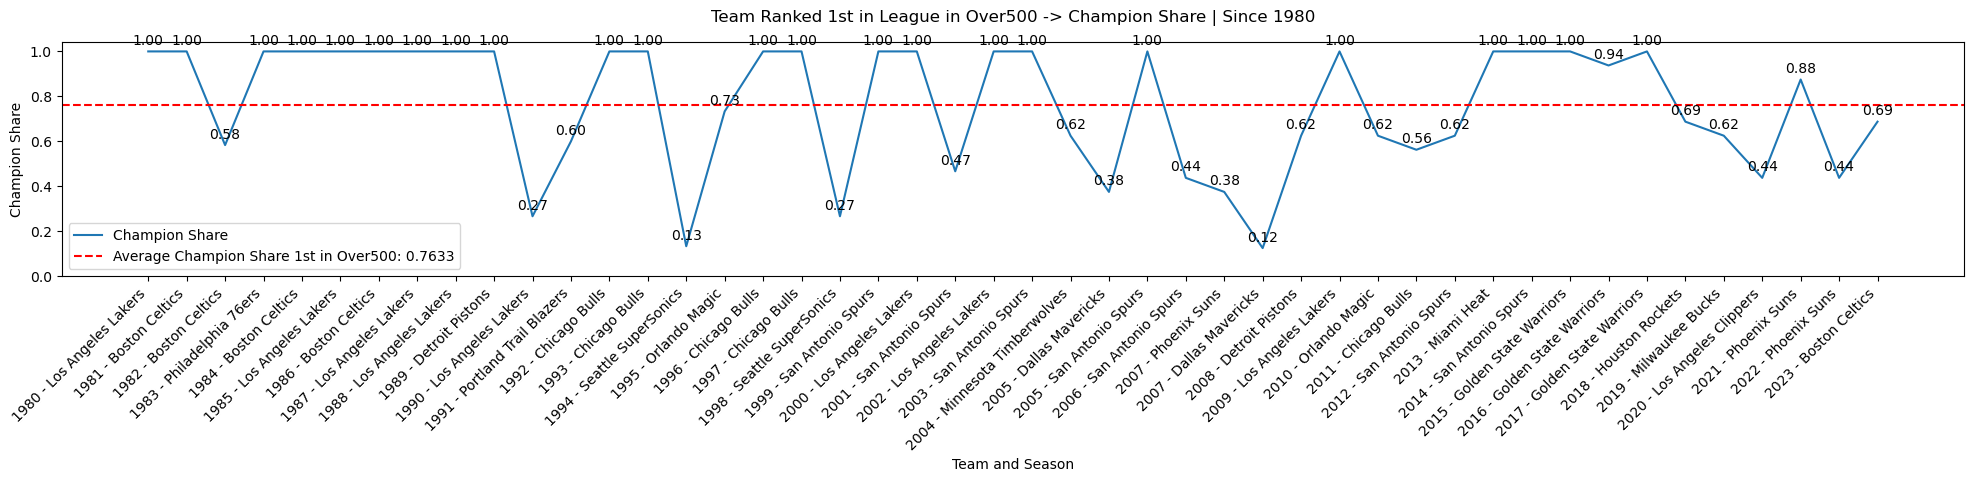

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

df = pd.read_csv("NBA Champion LR Data.csv")
#df = pd.read_csv("NBA Champion RawData.csv")
#print(list(df.columns))
df.drop(df[df['Season'] < 1980].index, inplace = True)


df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
with warnings.catch_warnings():
    warnings.simplefilter('ignore', FutureWarning)

    first_in_league_o5 = df.loc[df['over500 rec'] == 1].copy()

    first_in_league_o5 .sort_values(by='Season', inplace=True)

    plt.figure(figsize=(20, 5))
    plt.title("Team Ranked 1st in League in Over500 -> Champion Share | Since 1980")

    plt.title("Team Ranked 1st in League in Over500 -> Champion Share | Since 1980", y=1.05)

    first_in_league_o5.loc[:, 'Season'] = first_in_league_o5['Season'].astype(str)

    sns.lineplot(x=first_in_league_o5['Season'] + " - " + first_in_league_o5['Team'],
             y=first_in_league_o5['champion share'],
             label="Champion Share", errorbar=None)

    plt.xticks(rotation=45, ha="right")

    for i, row in first_in_league_o5.iterrows():
        plt.annotate(f"{row['champion share']:.2f}", (row['Season'] + " - " + row['Team'], row['champion share']),
                 textcoords="offset points", xytext=(0, 5), ha='center')

    average_champion_share = first_in_league_o5['champion share'].mean()
    plt.axhline(y=average_champion_share, color='r', linestyle='--', label=f'Average Champion Share 1st in Over500: {average_champion_share:.4f}')

    plt.xlabel("Team and Season")
    plt.ylabel("Champion Share")

    plt.ylim(bottom=0)
    plt.legend()
    plt.tight_layout()
    
    #save the fig
    plt.savefig("chp_over500_line.png", bbox_inches='tight', pad_inches=0.1)
    image = Image.open("chp_over500_line.png")
    image_with_border = ImageOps.expand(image, border=2, fill='black')
    image_with_border.save("chp_over500_line.png")
    
    plt.show()

In [31]:
16 * .7633

12.2128

In [49]:
champions_df = df[df['champion'] == 1.00]

unique_ranks = champions_df['over500 rec'].unique()

percentage_results = {}

for rank in unique_ranks:
    champions_with_rank = champions_df[champions_df['over500 rec'] == rank]
    total_champions = champions_df.shape[0]
    percentage = (champions_with_rank.shape[0] / total_champions) * 100
    percentage_results[f'Rank {rank}'] = percentage

sorted_results = sorted(percentage_results.items(), key=lambda x: x[1], reverse=True)

for rank, percentage in sorted_results:
    print(f"The percentage of champions over500 rec rank {rank}: {percentage:.2f}%")

The percentage of champions over500 rec rank Rank 1.0: 52.27%
The percentage of champions over500 rec rank Rank 2.0: 13.64%
The percentage of champions over500 rec rank Rank 3.0: 9.09%
The percentage of champions over500 rec rank Rank 5.0: 9.09%
The percentage of champions over500 rec rank Rank 7.0: 4.55%
The percentage of champions over500 rec rank Rank 4.0: 4.55%
The percentage of champions over500 rec rank Rank 8.0: 2.27%
The percentage of champions over500 rec rank Rank 9.0: 2.27%
The percentage of champions over500 rec rank Rank 12.0: 2.27%


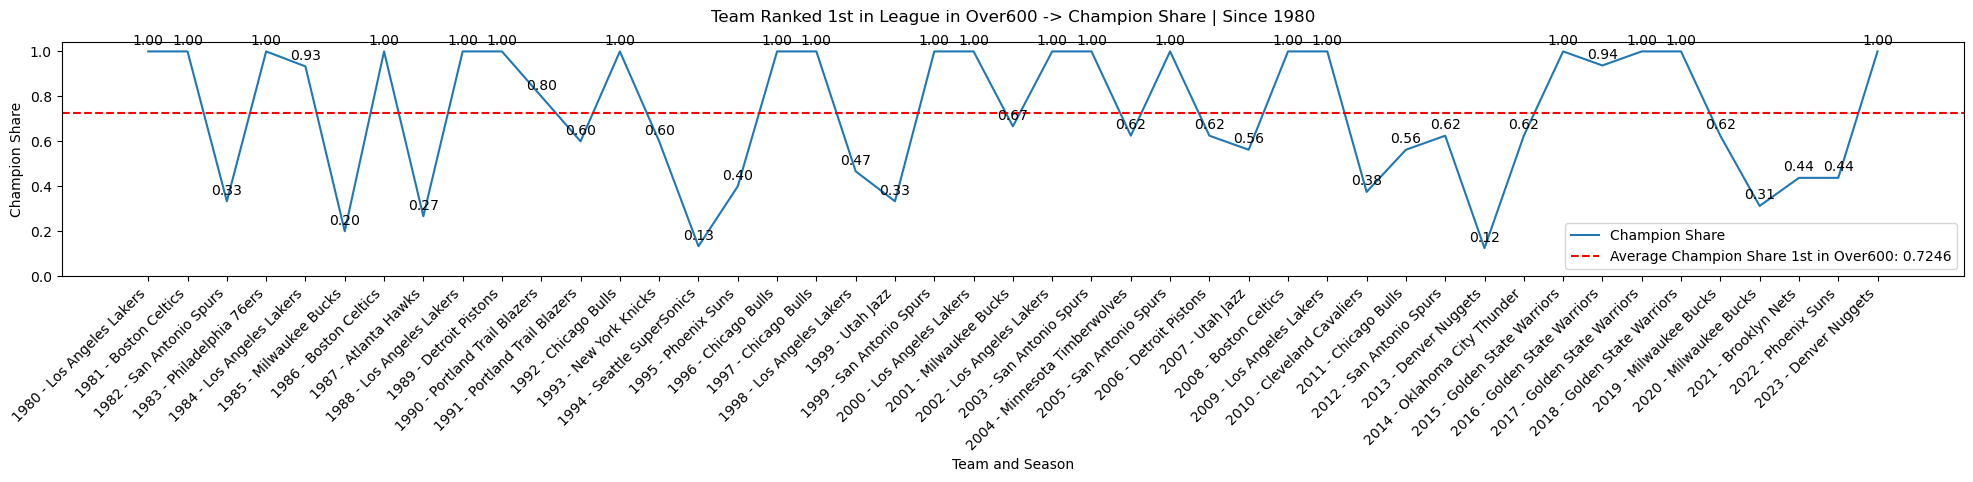

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

df = pd.read_csv("NBA Champion LR Data.csv")
#df = pd.read_csv("NBA Champion RawData.csv")
#print(list(df.columns))
df.drop(df[df['Season'] < 1980].index, inplace = True)


df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
with warnings.catch_warnings():
    warnings.simplefilter('ignore', FutureWarning)

    first_in_league_o5 = df.loc[df['over600 rec'] == 1].copy()

    first_in_league_o5 .sort_values(by='Season', inplace=True)

    plt.figure(figsize=(20, 5))
    plt.title("Team Ranked 1st in League in Over600 -> Champion Share | Since 1980")

    plt.title("Team Ranked 1st in League in Over600 -> Champion Share | Since 1980", y=1.05)

    first_in_league_o5.loc[:, 'Season'] = first_in_league_o5['Season'].astype(str)

    sns.lineplot(x=first_in_league_o5['Season'] + " - " + first_in_league_o5['Team'],
             y=first_in_league_o5['champion share'],
             label="Champion Share", errorbar=None)

    plt.xticks(rotation=45, ha="right")

    for i, row in first_in_league_o5.iterrows():
        plt.annotate(f"{row['champion share']:.2f}", (row['Season'] + " - " + row['Team'], row['champion share']),
                 textcoords="offset points", xytext=(0, 5), ha='center')

    average_champion_share = first_in_league_o5['champion share'].mean()
    plt.axhline(y=average_champion_share, color='r', linestyle='--', label=f'Average Champion Share 1st in Over600: {average_champion_share:.4f}')

    plt.xlabel("Team and Season")
    plt.ylabel("Champion Share")

    plt.ylim(bottom=0)
    plt.legend()
    plt.tight_layout()
    
    #save the fig
    plt.savefig("chp_over600_line.png", bbox_inches='tight', pad_inches=0.1)
    image = Image.open("chp_over600_line.png")
    image_with_border = ImageOps.expand(image, border=2, fill='black')
    image_with_border.save("chp_over600_line.png")
    
    plt.show()

In [51]:
champions_df = df[df['champion'] == 1.00]

unique_ranks = champions_df['over600 rec'].unique()

percentage_results = {}

for rank in unique_ranks:
    champions_with_rank = champions_df[champions_df['over600 rec'] == rank]
    total_champions = champions_df.shape[0]
    percentage = (champions_with_rank.shape[0] / total_champions) * 100
    percentage_results[f'Rank {rank}'] = percentage

sorted_results = sorted(percentage_results.items(), key=lambda x: x[1], reverse=True)

for rank, percentage in sorted_results:
    print(f"The percentage of champions over600 rec rank {rank}: {percentage:.2f}%")

The percentage of champions over600 rec rank Rank 1.0: 45.45%
The percentage of champions over600 rec rank Rank 2.0: 13.64%
The percentage of champions over600 rec rank Rank 4.0: 9.09%
The percentage of champions over600 rec rank Rank 3.0: 9.09%
The percentage of champions over600 rec rank Rank 5.0: 6.82%
The percentage of champions over600 rec rank Rank 11.0: 2.27%
The percentage of champions over600 rec rank Rank 8.0: 2.27%
The percentage of champions over600 rec rank Rank 6.0: 2.27%
The percentage of champions over600 rec rank Rank 23.0: 2.27%
The percentage of champions over600 rec rank Rank 10.0: 2.27%
The percentage of champions over600 rec rank Rank 12.0: 2.27%
The percentage of champions over600 rec rank Rank 9.0: 2.27%


### Pre-Playoff Odds (Ceasers SportsBook) via (SportsOddsHistory)

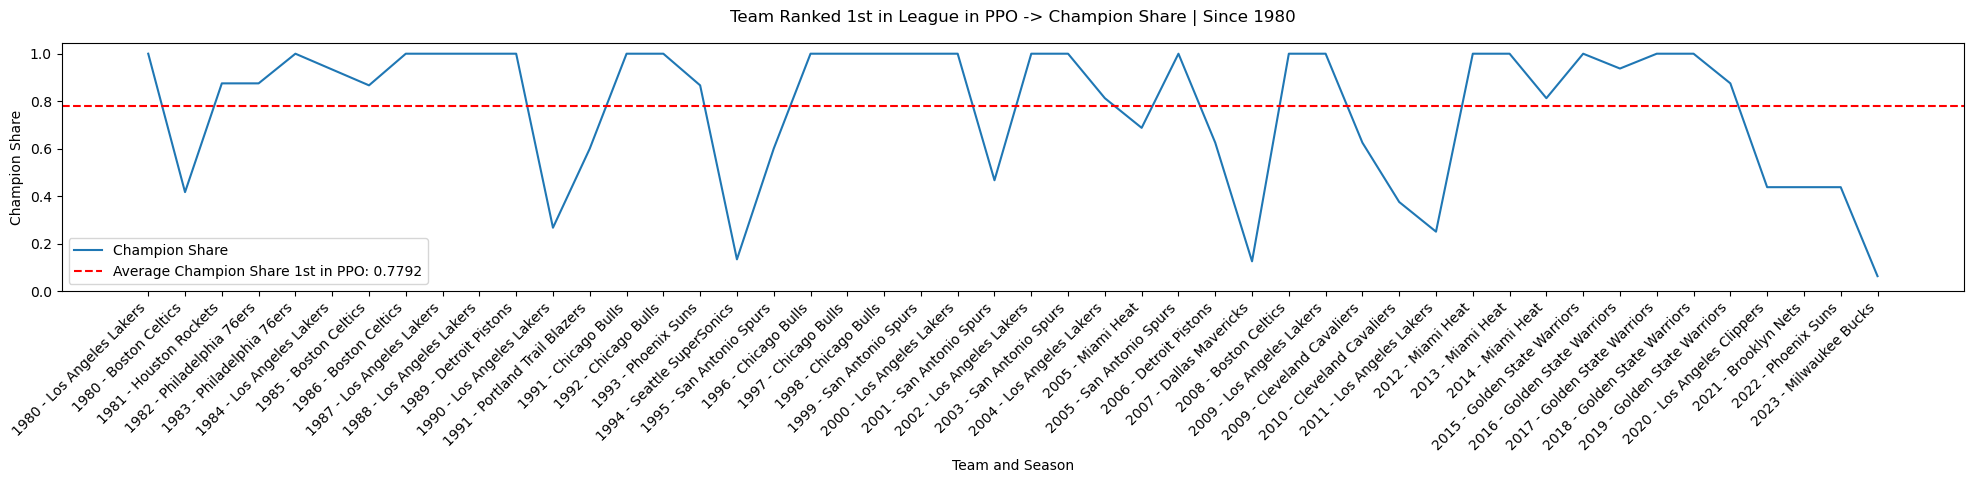

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

df = pd.read_csv("NBA Champion LR Data.csv")
#df = pd.read_csv("NBA Champion RawData.csv")
#print(list(df.columns))
df.drop(df[df['Season'] < 1980].index, inplace = True)


df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
with warnings.catch_warnings():
    warnings.simplefilter('ignore', FutureWarning)

    first_in_league_ppo = df.loc[df['pre playoff odds rank'] == 1].copy()

    first_in_league_ppo .sort_values(by='Season', inplace=True)

    plt.figure(figsize=(20, 5))
    plt.title("Team Ranked 1st in League in PPO -> Champion Share | Since 1980")

    plt.title("Team Ranked 1st in League in PPO -> Champion Share | Since 1980", y=1.05)

    first_in_league_ppo.loc[:, 'Season'] = first_in_league_ppo['Season'].astype(str)

    sns.lineplot(x=first_in_league_ppo['Season'] + " - " + first_in_league_ppo['Team'],
             y=first_in_league_ppo['champion share'],
             label="Champion Share", errorbar=None)

    plt.xticks(rotation=45, ha="right")

    average_champion_share = first_in_league_ppo['champion share'].mean()
    plt.axhline(y=average_champion_share, color='r', linestyle='--', label=f'Average Champion Share 1st in PPO: {average_champion_share:.4f}')

    plt.xlabel("Team and Season")
    plt.ylabel("Champion Share")

    plt.ylim(bottom=0)

    plt.legend()
    plt.tight_layout()
    
    plt.savefig("chp_PPO_line.png", bbox_inches='tight', pad_inches=0.1)
    image = Image.open("chp_PPO_line.png")
    image_with_border = ImageOps.expand(image, border=2, fill='black')
    image_with_border.save("chp_PPO_line.png")
    
    plt.show()

In [64]:
print(list(df.columns))

['Season', 'Team/Season', 'Team', 'Team ID', 'Team ID/Season', 'Conference', 'Conference/Season', 'curr/past mvp or past fmvp', 'Conference 5=> rec', 'pre playoff odds', 'pre playoff odds rank', 'pre season odds', 'champion', 'champion share', 'make playoffs', 'top 3 conference', 'rk conference', 'overall record', 'over500 rec', 'over600 rec', '20 =< wins', '5 => rec', 'sum coach playoff games', 'sum coy shares', 'sum playoff games', 'sum champion', 'sum champion share', 'sum mvp shares', 'sum all defense', 'sum all nba', 'sum dpoy shares', 'sum smoy shares', 'sum mip shares', 'sum all stars', 'sum player L1Y cs', 'sum player L3Y cs', 'sum player L5Y cs', 'sum player L8Y cs', 'sum player L10Y cs', 'sum L3Y mvp shares ', 'sum L5Y  mvp shares', 'sum franchise L1Y cs', 'sum franchise L3Y cs', 'sum franchise L5Y cs', 'sum franchise L8Y cs', 'sum franchise L10Y cs', 'team_rating_custom', 'max_player_rating', 'curr/past mvp or past fmvp.1', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA'

In [85]:
16 * .7792

12.4672

In [55]:
champions_df = df[df['champion'] == 1.00]
unique_ranks = champions_df['pre playoff odds rank'].unique()
percentage_results = {}

for rank in unique_ranks:
    champions_with_rank = champions_df[champions_df['pre playoff odds rank'] == rank]
    total_champions = champions_df.shape[0]
    percentage = (champions_with_rank.shape[0] / total_champions) * 100
    percentage_results[f'Rank {rank}'] = percentage

sorted_results = sorted(percentage_results.items(), key=lambda x: x[1], reverse=True)

for rank, percentage in sorted_results:
    print(f"The percentage of champions with pre playoff odds rank {rank}: {percentage:.2f}%")

The percentage of champions with pre playoff odds rank Rank 1: 52.27%
The percentage of champions with pre playoff odds rank Rank 2: 20.45%
The percentage of champions with pre playoff odds rank Rank 3: 11.36%
The percentage of champions with pre playoff odds rank Rank 5: 6.82%
The percentage of champions with pre playoff odds rank Rank 6: 2.27%
The percentage of champions with pre playoff odds rank Rank 4: 2.27%
The percentage of champions with pre playoff odds rank Rank 7: 2.27%
The percentage of champions with pre playoff odds rank Rank 9: 2.27%


## Ceasars Sportsbook Pre Playoff Odds are really good.... (data from Sports Odds History)
- Teams that ranked 1st in PPO won the NBA championship 53.19% of the time since 1980.
- On average the team ranked 1st in PPO reached the finals, with that number being 12.46 playoff wins (champion share .7792).
- Either the NBA has been quite predictable in the past, or Vegas is a genius, or maybe both.
- Keep in mind Vegas as been wrong in the last 5 NBA seasons (2023-2019), the NBA is more competitive than ever now

In [1]:
53.19+19.15+10.64

82.98

In [29]:
df = pd.read_csv("NBA Champion LR Data.csv")
print(list(df.columns))

['Season', 'Team/Season', 'Team', 'Team ID', 'Team ID/Season', 'Conference', 'Conference/Season', 'Conference 5=> rec', 'pre playoff odds', 'pre playoff odds rank', 'pre season odds', 'champion', 'champion share', 'make playoffs', 'top 3 conference', 'rk conference', 'overall record', 'over500 rec', 'over600 rec', '20 =< wins', '5 => rec', 'sum coach playoff games', 'sum coy shares', 'sum playoff games', 'sum champion', 'sum champion share', 'sum mvp shares', 'sum all defense', 'sum all nba', 'sum dpoy shares', 'sum smoy shares', 'sum mip shares', 'sum all stars', 'sum player L1Y cs', 'sum player L3Y cs', 'sum player L5Y cs', 'sum player L8Y cs', 'sum player L10Y cs', 'sum L3Y mvp shares ', 'sum L5Y  mvp shares', 'sum franchise L1Y cs', 'sum franchise L3Y cs', 'sum franchise L5Y cs', 'sum franchise L8Y cs', 'sum franchise L10Y cs', 'team_rating_custom', 'max_player_rating', 'curr/past mvp or past fmvp', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%', 'OR

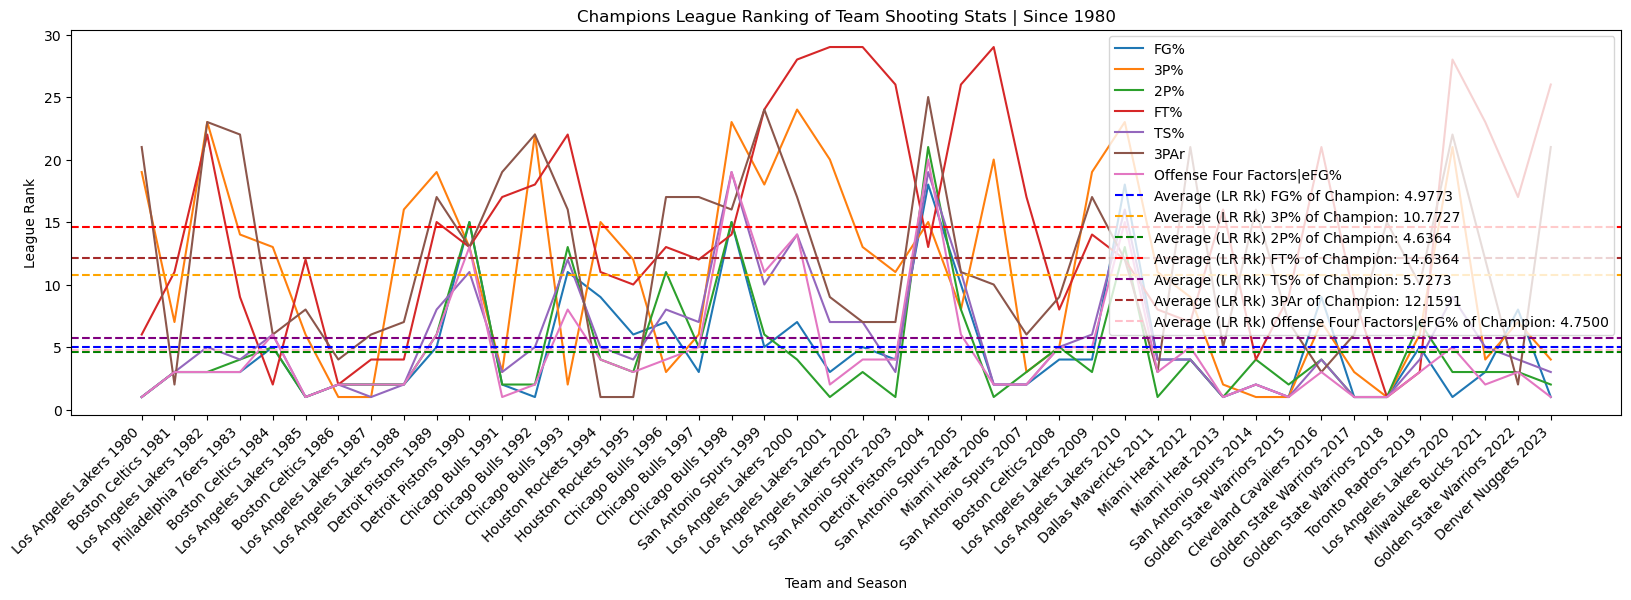

In [28]:
import warnings

df = pd.read_csv("NBA Champion LR Data.csv")
#df = pd.read_csv("NBA Champion RawData.csv")
df.drop(df[df['Season'] < 1980].index, inplace = True)

df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
with warnings.catch_warnings():
    warnings.simplefilter('ignore', FutureWarning)

    champion_sea = df.loc[df['champion share'] == 1].copy()  
    champion_sea.sort_values(by='Season', inplace=True)
    champion_sea['Season'] = champion_sea['Season'].astype(str)

    plt.figure(figsize=(20, 5))
    plt.title("Champions League Ranking of Team Shooting Stats | Since 1980")
    sns.lineplot(x=champion_sea['Team'] + ' ' + champion_sea['Season'], y=champion_sea['FG%'], label='FG%')
    sns.lineplot(x=champion_sea['Team'] + ' ' + champion_sea['Season'], y=champion_sea['3P%'], label='3P%')
    sns.lineplot(x=champion_sea['Team'] + ' ' + champion_sea['Season'], y=champion_sea['2P%'], label='2P%')
    sns.lineplot(x=champion_sea['Team'] + ' ' + champion_sea['Season'], y=champion_sea['FT%'], label='FT%')
    sns.lineplot(x=champion_sea['Team'] + ' ' + champion_sea['Season'], y=champion_sea['TS%'], label='TS%')
    sns.lineplot(x=champion_sea['Team'] + ' ' + champion_sea['Season'], y=champion_sea['3PAr'], label='3PAr')
    sns.lineplot(x=champion_sea['Team'] + ' ' + champion_sea['Season'], y=champion_sea['Offense Four Factors|eFG%'], label='Offense Four Factors|eFG%')

    average_fg = champion_sea['FG%'].mean()
    average_3p = champion_sea['3P%'].mean()
    average_2p = champion_sea['2P%'].mean()
    average_fr = champion_sea['FT%'].mean()
    average_ts = champion_sea['TS%'].mean()
    average_3pr = champion_sea['3PAr'].mean()
    average_efg = champion_sea['Offense Four Factors|eFG%'].mean()

    plt.axhline(y=average_fg, color='blue', linestyle='--', label=f'Average (LR Rk) FG% of Champion: {average_fg:.4f}')
    plt.axhline(y=average_3p, color='orange', linestyle='--', label=f'Average (LR Rk) 3P% of Champion: {average_3p:.4f}')
    plt.axhline(y=average_2p, color='green', linestyle='--', label=f'Average (LR Rk) 2P% of Champion: {average_2p:.4f}')
    plt.axhline(y=average_fr, color='red', linestyle='--', label=f'Average (LR Rk) FT% of Champion: {average_fr:.4f}')
    plt.axhline(y=average_ts, color='purple', linestyle='--', label=f'Average (LR Rk) TS% of Champion: {average_ts:.4f}')
    plt.axhline(y=average_3pr, color='brown', linestyle='--', label=f'Average (LR Rk) 3PAr of Champion: {average_3pr:.4f}')
    plt.axhline(y=average_efg, color='pink', linestyle='--', label=f'Average (LR Rk) Offense Four Factors|eFG% of Champion: {average_efg:.4f}')

    plt.xlabel('Team and Season')
    plt.ylabel('League Rank')

    plt.xticks(rotation=45, ha='right')
    plt.legend()

    plt.savefig("nbaLR_chps_sht_stats.png", bbox_inches='tight', pad_inches=0.1)
    image = Image.open("nbaLR_chps_sht_stats.png")
    image_with_border = ImageOps.expand(image, border=2, fill='black')
    image_with_border.save("nbaLR_chps_sht_stats.png")

    plt.show()

In [56]:
df = pd.read_csv("NBA Champion LR Data.csv")
print(list(df.columns))

['Season', 'Team/Season', 'Team', 'Team ID', 'Team ID/Season', 'Conference', 'Conference/Season', 'Conference 5=> rec', 'pre playoff odds', 'pre playoff odds rank', 'pre season odds', 'champion', 'champion share', 'make playoffs', 'top 3 conference', 'rk conference', 'overall record', 'over500 rec', 'over600 rec', '20 =< wins', '5 => rec', 'sum coach playoff games', 'sum coy shares', 'sum playoff games', 'sum champion', 'sum champion share', 'sum mvp shares', 'sum all defense', 'sum all nba', 'sum dpoy shares', 'sum smoy shares', 'sum mip shares', 'sum all stars', 'sum player L1Y cs', 'sum player L3Y cs', 'sum player L5Y cs', 'sum player L8Y cs', 'sum player L10Y cs', 'sum L3Y mvp shares ', 'sum L5Y  mvp shares', 'sum franchise L1Y cs', 'sum franchise L3Y cs', 'sum franchise L5Y cs', 'sum franchise L8Y cs', 'sum franchise L10Y cs', 'team_rating_custom', 'max_player_rating', 'curr/past mvp or past fmvp', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%', 'OR

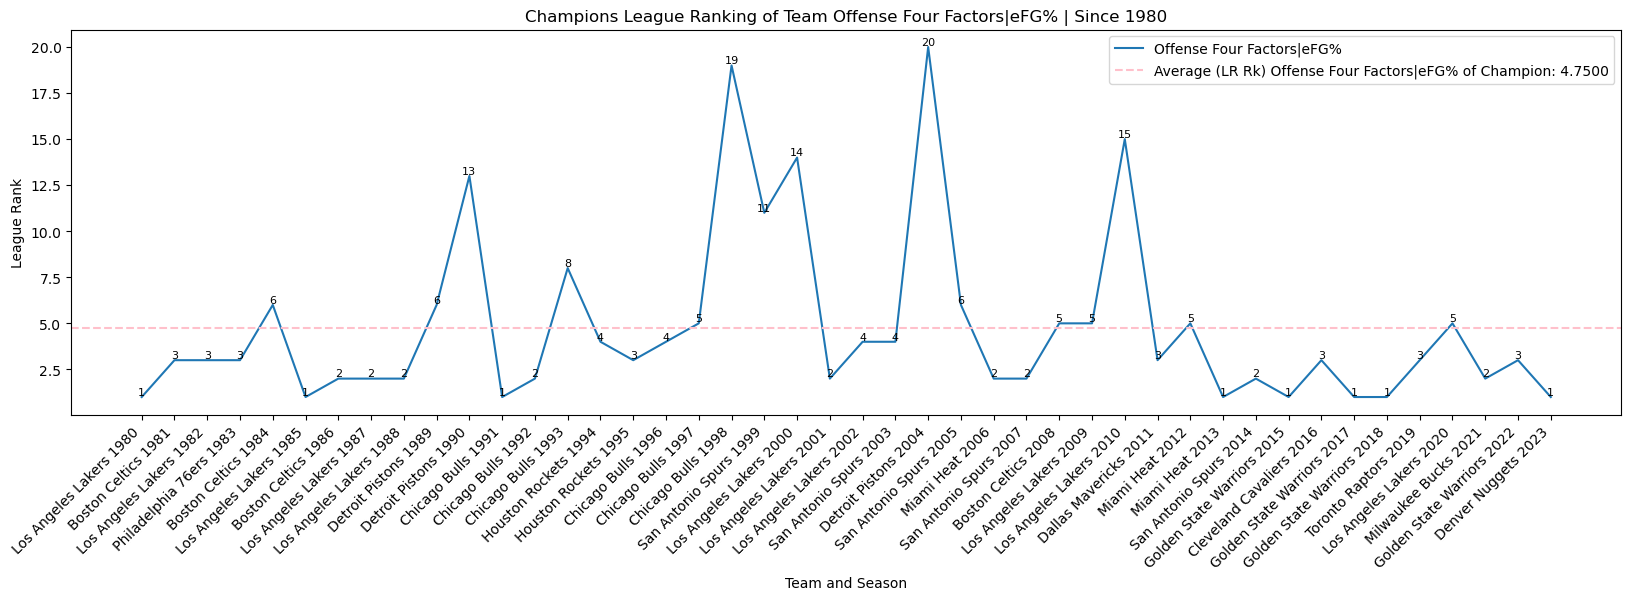

In [15]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("NBA Champion LR Data.csv")
df.drop(df[df['Season'] < 1980].index, inplace=True)

df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

with warnings.catch_warnings():
    warnings.simplefilter('ignore', FutureWarning)

    champion_sea = df.loc[df['champion share'] == 1].copy()
    champion_sea.sort_values(by='Season', inplace=True)
    champion_sea['Season'] = champion_sea['Season'].astype(str)

    plt.figure(figsize=(20, 5))
    plt.title("Champions League Ranking of Team Offense Four Factors|eFG% | Since 1980")

    sns.lineplot(x=champion_sea['Team'] + ' ' + champion_sea['Season'], y=champion_sea['Offense Four Factors|eFG%'], label='Offense Four Factors|eFG%')

    average_efg = champion_sea['Offense Four Factors|eFG%'].mean()

    plt.axhline(y=average_efg, color='pink', linestyle='--', label=f'Average (LR Rk) Offense Four Factors|eFG% of Champion: {average_efg:.4f}')

    # Add data labels
    for i, (team_season, efg) in enumerate(zip(champion_sea['Team'] + ' ' + champion_sea['Season'], champion_sea['Offense Four Factors|eFG%'])):
        plt.text(i, efg, f'{efg:.0f}', ha='center', va='bottom', rotation=0, fontsize=8, color='black')

    plt.xlabel('Team and Season')
    plt.ylabel('League Rank')

    plt.xticks(rotation=45, ha='right')
    plt.legend()
    
    plt.savefig("nba_chp_eFG_line.png", bbox_inches='tight', pad_inches=0.1)
    image = Image.open("nba_chp_eFG_line.png")
    image_with_border = ImageOps.expand(image, border=2, fill='black')
    image_with_border.save("nba_chp_eFG_line.png")

    plt.show()

In [32]:
champions_df = df[df['champion'] == 1.00]
unique_ranks = champions_df['Offense Four Factors|eFG%'].unique()
percentage_results = {}

for rank in unique_ranks:
    champions_with_rank = champions_df[champions_df['Offense Four Factors|eFG%'] == rank]
    total_champions = champions_df.shape[0]
    percentage = (champions_with_rank.shape[0] / total_champions) * 100
    percentage_results[f'Rank {rank}'] = percentage

sorted_results = sorted(percentage_results.items(), key=lambda x: x[1], reverse=True)

for rank, percentage in sorted_results:
    print(f"The percentage of champions with Offense Four Factors|eFG% {rank}: {percentage:.2f}%")

The percentage of champions with Offense Four Factors|eFG% Rank 2.0: 18.92%
The percentage of champions with Offense Four Factors|eFG% Rank 3.0: 16.22%
The percentage of champions with Offense Four Factors|eFG% Rank 1.0: 14.86%
The percentage of champions with Offense Four Factors|eFG% Rank 5.0: 10.81%
The percentage of champions with Offense Four Factors|eFG% Rank 4.0: 8.11%
The percentage of champions with Offense Four Factors|eFG% Rank 6.0: 5.41%
The percentage of champions with Offense Four Factors|eFG% Rank 8.0: 5.41%
The percentage of champions with Offense Four Factors|eFG% Rank 9.0: 4.05%
The percentage of champions with Offense Four Factors|eFG% Rank 15.0: 2.70%
The percentage of champions with Offense Four Factors|eFG% Rank 11.0: 2.70%
The percentage of champions with Offense Four Factors|eFG% Rank 19.0: 2.70%
The percentage of champions with Offense Four Factors|eFG% Rank 7.0: 2.70%
The percentage of champions with Offense Four Factors|eFG% Rank 20.0: 1.35%
The percentage of

In [33]:
14.86+18.92+16.22+8.11+10.81

68.92

In [98]:
df = pd.read_csv("NBA Champion LR Data.csv")
print(list(df.columns))

['Season', 'Team/Season', 'Team', 'Team ID', 'Team ID/Season', 'Conference', 'Conference/Season', 'Conference 5=> rec', 'Conference OR', 'Conference SRS', 'Conference Age', 'pre playoff odds', 'pre playoff odds rank', 'pre season odds', 'champion', 'champion share', 'make playoffs', 'top 3 conference', 'rk conference', 'overall record', 'over500 rec', 'over600 rec', '20 =< wins', '5 => rec', 'sum coach playoff games', 'sum coy shares', 'sum playoff games', 'sum champion', 'sum champion share', 'sum mvp shares', 'sum all defense', 'sum all nba', 'sum dpoy shares', 'sum smoy shares', 'sum mip shares', 'sum all stars', 'sum player L1Y cs', 'sum player L3Y cs', 'sum player L5Y cs', 'sum player L8Y cs', 'sum player L10Y cs', 'sum L3Y mvp shares ', 'sum L5Y  mvp shares', 'sum franchise L1Y cs', 'sum franchise L3Y cs', 'sum franchise L5Y cs', 'sum franchise L8Y cs', 'sum franchise L10Y cs', 'team_rating_custom', 'max_player_rating_custom', 'curr/past mvp or past fmvp', 'FG', 'FGA', 'FG%', '3P

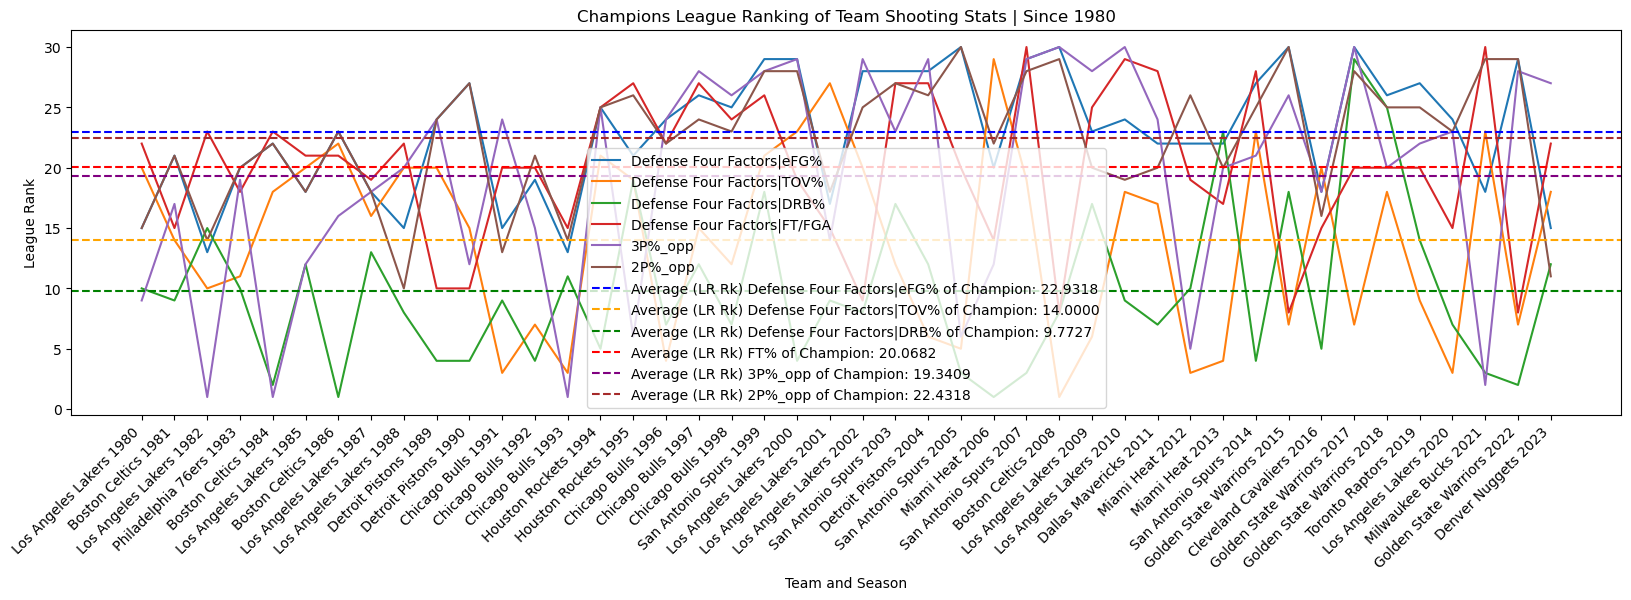

In [17]:
import warnings

df = pd.read_csv("NBA Champion LR Data.csv")
#df = pd.read_csv("NBA Champion RawData.csv")
df.drop(df[df['Season'] < 1980].index, inplace = True)

df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
with warnings.catch_warnings():
    warnings.simplefilter('ignore', FutureWarning)

    champion_sea = df.loc[df['champion share'] == 1].copy()  
    champion_sea.sort_values(by='Season', inplace=True)
    champion_sea['Season'] = champion_sea['Season'].astype(str)

    plt.figure(figsize=(20, 5))
    plt.title("Champions League Ranking of Team Shooting Stats | Since 1980")
    sns.lineplot(x=champion_sea['Team'] + ' ' + champion_sea['Season'], y=champion_sea['Defense Four Factors|eFG%'], label='Defense Four Factors|eFG%')
    sns.lineplot(x=champion_sea['Team'] + ' ' + champion_sea['Season'], y=champion_sea['Defense Four Factors|TOV%'], label='Defense Four Factors|TOV%')
    sns.lineplot(x=champion_sea['Team'] + ' ' + champion_sea['Season'], y=champion_sea['Defense Four Factors|DRB%'], label='Defense Four Factors|DRB%')
    sns.lineplot(x=champion_sea['Team'] + ' ' + champion_sea['Season'], y=champion_sea['Defense Four Factors|FT/FGA'], label='Defense Four Factors|FT/FGA')
    sns.lineplot(x=champion_sea['Team'] + ' ' + champion_sea['Season'], y=champion_sea['3P%_opp'], label='3P%_opp')
    sns.lineplot(x=champion_sea['Team'] + ' ' + champion_sea['Season'], y=champion_sea['2P%_opp'], label='2P%_opp')

    average_efg = champion_sea['Defense Four Factors|eFG%'].mean()
    average_tov = champion_sea['Defense Four Factors|TOV%'].mean()
    average_drb = champion_sea['Defense Four Factors|DRB%'].mean()
    average_ft = champion_sea['Defense Four Factors|FT/FGA'].mean()
    average_3p = champion_sea['3P%_opp'].mean()
    average_2p = champion_sea['2P%_opp'].mean()

    plt.axhline(y=average_efg, color='blue', linestyle='--', label=f'Average (LR Rk) Defense Four Factors|eFG% of Champion: {average_efg:.4f}')
    plt.axhline(y=average_tov, color='orange', linestyle='--', label=f'Average (LR Rk) Defense Four Factors|TOV% of Champion: {average_tov:.4f}')
    plt.axhline(y=average_drb, color='green', linestyle='--', label=f'Average (LR Rk) Defense Four Factors|DRB% of Champion: {average_drb:.4f}')
    plt.axhline(y=average_ft, color='red', linestyle='--', label=f'Average (LR Rk) FT% of Champion: {average_ft:.4f}')
    plt.axhline(y=average_3p, color='purple', linestyle='--', label=f'Average (LR Rk) 3P%_opp of Champion: {average_3p:.4f}')
    plt.axhline(y=average_2p, color='brown', linestyle='--', label=f'Average (LR Rk) 2P%_opp of Champion: {average_2p:.4f}')

    plt.xlabel('Team and Season')
    plt.ylabel('League Rank')

    plt.xticks(rotation=45, ha='right')
    plt.legend()

    plt.savefig("nbaLR_chps_def_stats.png", bbox_inches='tight', pad_inches=0.1)
    image = Image.open("nbaLR_chps_def_stats.png")
    image_with_border = ImageOps.expand(image, border=2, fill='black')
    image_with_border.save("nbaLR_chps_def_stats.png")

    plt.show()

Column Averages:
Conference 5=> rec    6.909091
dtype: float64


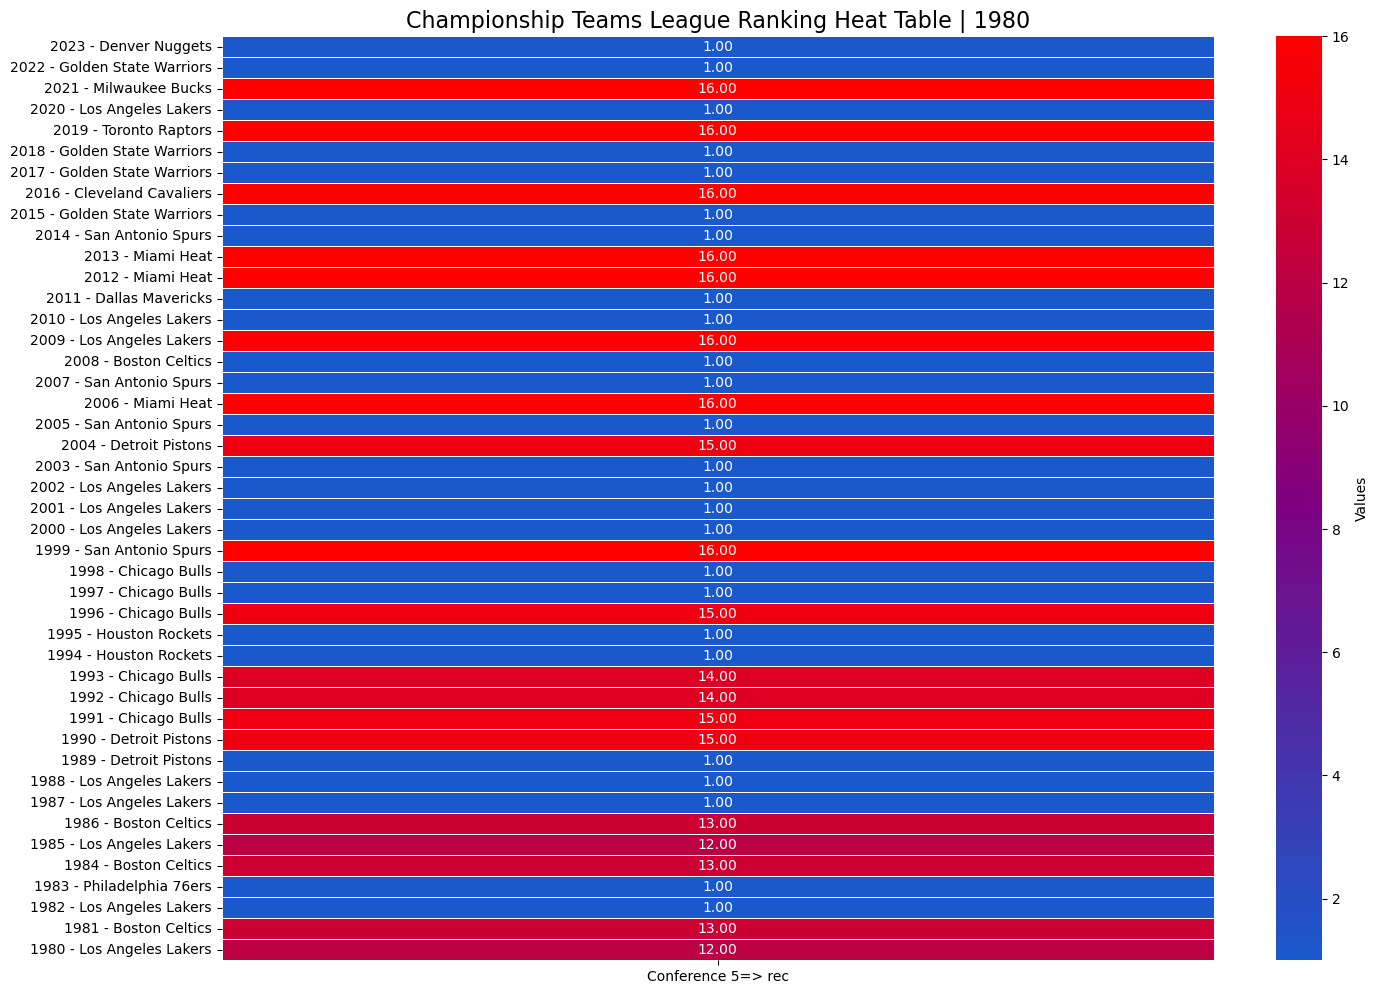

In [90]:
from matplotlib.colors import ListedColormap
df = pd.read_csv("NBA Champion LR Data.csv")
#df = pd.read_csv("NBA Champion RawData.csv")
df.drop(df[df['Season'] < 1980].index, inplace = True)

champions_only = df[df['champion share'] == 1]

custom_palette = sns.color_palette("pastel", as_cmap=True)

large_color = 'red'  
middle_color = 'purple'
small_color = (0.1, 0.35, .8)

large_threshold = 1.5  
middle_threshold = 0.5 

colors = sns.color_palette([small_color, middle_color, large_color], as_cmap=True)
custom_cmap = sns.blend_palette(colors, as_cmap=True)

plt.figure(figsize=(16, 12))
heatmap_data = champions_only[['Conference 5=> rec']]

heatmap = sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap=custom_cmap, linewidths=.5, cbar_kws={'label': 'Values'}, vmin=heatmap_data.min().min(), vmax=heatmap_data.max().max())

championship_teams_labels = ['{} - {}'.format(season, team) for season, team in zip(champions_only['Season'], champions_only['Team'])]
plt.yticks(ticks=[i + 0.5 for i in range(len(championship_teams_labels))], labels=championship_teams_labels, rotation=0)

column_averages = heatmap_data.mean()
print("Column Averages:")
print(column_averages)

plt.title('Championship Teams League Ranking Heat Table | 1980', fontsize=16)
plt.savefig("ht_allChamps_cf_str_fea.png", bbox_inches='tight', pad_inches=0.1)
image = Image.open("ht_allChamps_cf_str_fea.png")
image_with_border = ImageOps.expand(image, border=2, fill='black')
image_with_border.save("ht_allChamps_cf_str_fea.png")

plt.show()

In [91]:
champions_df = df[df['champion'] == 1.00]
unique_ranks = champions_df['Conference 5=> rec'].unique()
percentage_results = {}

for rank in unique_ranks:
    champions_with_rank = champions_df[champions_df['Conference 5=> rec'] == rank]
    total_champions = champions_df.shape[0]
    percentage = (champions_with_rank.shape[0] / total_champions) * 100
    percentage_results[f'Rank {rank}'] = percentage

sorted_results = sorted(percentage_results.items(), key=lambda x: x[1], reverse=True)

for rank, percentage in sorted_results:
    print(f"The percentage of champions with Conference 5=> rec {rank}: {percentage:.2f}%")

The percentage of champions with Conference 5=> rec Rank 1.0: 56.82%
The percentage of champions with Conference 5=> rec Rank 16.0: 18.18%
The percentage of champions with Conference 5=> rec Rank 15.0: 9.09%
The percentage of champions with Conference 5=> rec Rank 13.0: 6.82%
The percentage of champions with Conference 5=> rec Rank 14.0: 4.55%
The percentage of champions with Conference 5=> rec Rank 12.0: 4.55%


In [31]:
df = pd.read_csv("NBA Champion LR Data.csv")
print(list(df.columns))

['Season', 'Team/Season', 'Team', 'Team ID', 'Team ID/Season', 'Conference', 'Conference/Season', 'Conference 5=> rec', 'Conference OR', 'Conference SRS', 'Conference Age', 'pre playoff odds', 'pre playoff odds rank', 'pre season odds', 'champion', 'champion share', 'make playoffs', 'top 3 conference', 'rk conference', 'overall record', 'over500 rec', 'over600 rec', '20 =< wins', '5 => rec', 'sum coach playoff games', 'sum coy shares', 'sum playoff games', 'sum champion', 'sum champion share', 'sum mvp shares', 'sum all defense', 'sum all nba', 'sum dpoy shares', 'sum smoy shares', 'sum mip shares', 'sum all stars', 'sum player L1Y cs', 'sum player L3Y cs', 'sum player L5Y cs', 'sum player L8Y cs', 'sum player L10Y cs', 'sum L3Y mvp shares ', 'sum L5Y  mvp shares', 'sum franchise L1Y cs', 'sum franchise L3Y cs', 'sum franchise L5Y cs', 'sum franchise L8Y cs', 'sum franchise L10Y cs', 'team_rating_custom', 'max_player_rating_custom', 'curr/past mvp or past fmvp', 'FG', 'FGA', 'FG%', '3P

Column Averages:
Conference OR    7.25
dtype: float64


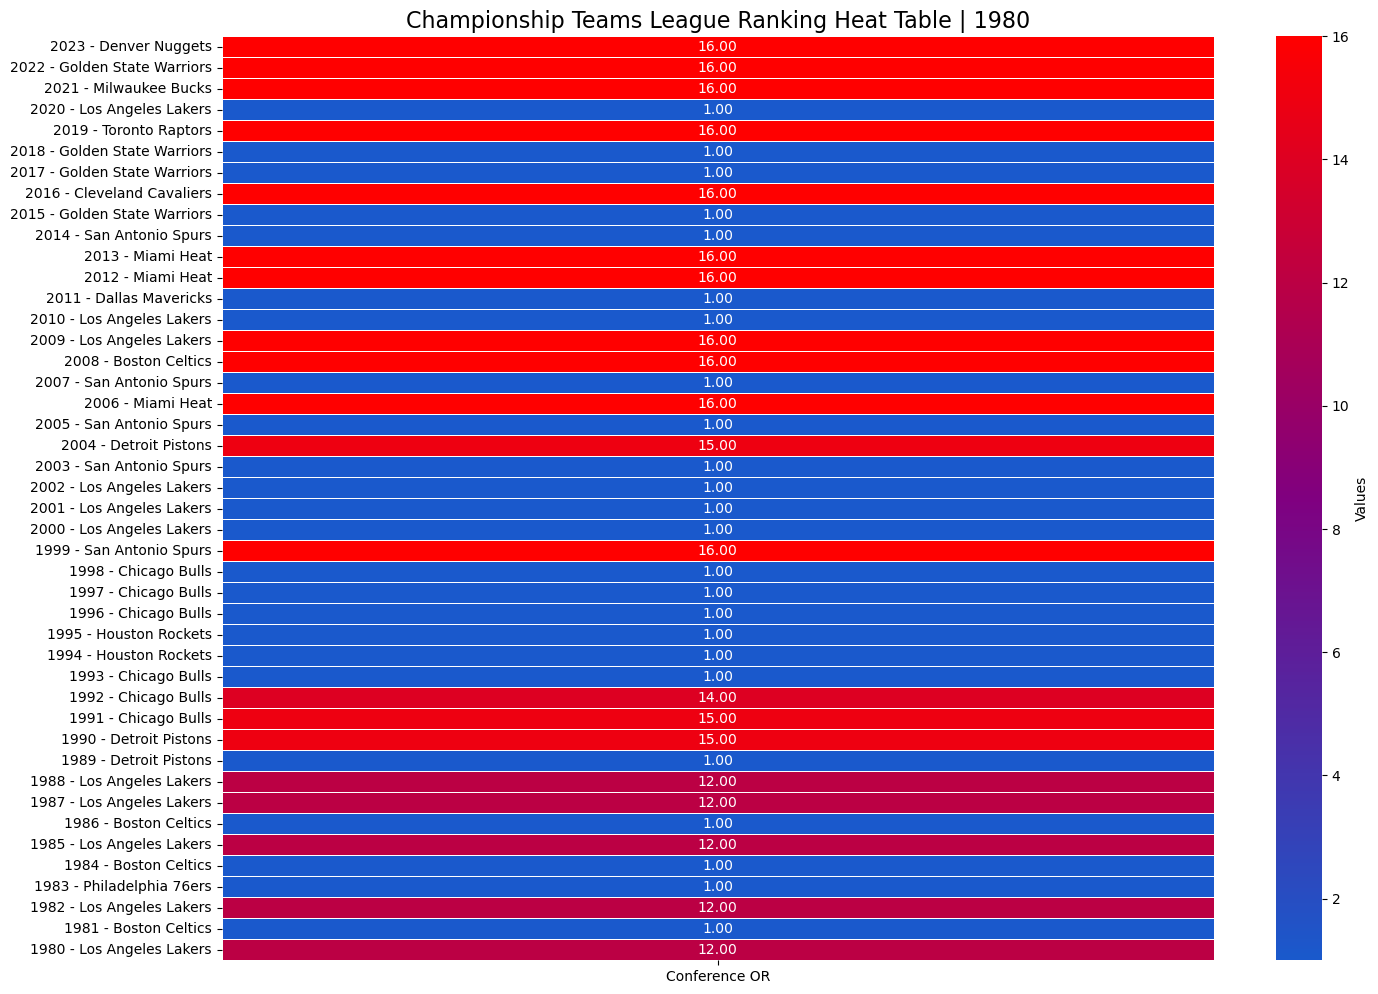

In [101]:
from matplotlib.colors import ListedColormap
df = pd.read_csv("NBA Champion LR Data.csv")
#df = pd.read_csv("NBA Champion RawData.csv")
df.drop(df[df['Season'] < 1980].index, inplace = True)

champions_only = df[df['champion share'] == 1]

custom_palette = sns.color_palette("pastel", as_cmap=True)

large_color = 'red'  
middle_color = 'purple'
small_color = (0.1, 0.35, .8)

large_threshold = 1.5  
middle_threshold = 0.5 

colors = sns.color_palette([small_color, middle_color, large_color], as_cmap=True)
custom_cmap = sns.blend_palette(colors, as_cmap=True)

plt.figure(figsize=(16, 12))
heatmap_data = champions_only[['Conference OR']]

heatmap = sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap=custom_cmap, linewidths=.5, cbar_kws={'label': 'Values'}, vmin=heatmap_data.min().min(), vmax=heatmap_data.max().max())

championship_teams_labels = ['{} - {}'.format(season, team) for season, team in zip(champions_only['Season'], champions_only['Team'])]
plt.yticks(ticks=[i + 0.5 for i in range(len(championship_teams_labels))], labels=championship_teams_labels, rotation=0)

column_averages = heatmap_data.mean()
print("Column Averages:")
print(column_averages)

plt.title('Championship Teams League Ranking Heat Table | 1980', fontsize=16)
#plt.savefig("ht_allChamps_cf_str_fea.png", bbox_inches='tight', pad_inches=0.1)
#image = Image.open("ht_allChamps_cf_str_fea.png")
#image_with_border = ImageOps.expand(image, border=2, fill='black')
#image_with_border.save("ht_allChamps_cf_str_fea.png")

plt.show()

In [102]:
champions_df = df[df['champion'] == 1.00]
unique_ranks = champions_df['Conference OR'].unique()
percentage_results = {}

for rank in unique_ranks:
    champions_with_rank = champions_df[champions_df['Conference OR'] == rank]
    total_champions = champions_df.shape[0]
    percentage = (champions_with_rank.shape[0] / total_champions) * 100
    percentage_results[f'Rank {rank}'] = percentage

sorted_results = sorted(percentage_results.items(), key=lambda x: x[1], reverse=True)

for rank, percentage in sorted_results:
    print(f"The percentage of champions with Conference OR {rank}: {percentage:.2f}%")

The percentage of champions with Conference OR Rank 1.0: 54.55%
The percentage of champions with Conference OR Rank 16.0: 25.00%
The percentage of champions with Conference OR Rank 12.0: 11.36%
The percentage of champions with Conference OR Rank 15.0: 6.82%
The percentage of champions with Conference OR Rank 14.0: 2.27%


In [103]:
df = pd.read_csv("NBA Champion RawData.csv")
print(list(df.columns))

['Season', 'Team/Season', 'Team', 'Team ID', 'Team ID/Season', 'Conference', 'Conference/Season', 'Conference 5=> rec', 'Conference OR', 'Conference SRS', 'Conference Age', 'pre playoff odds', 'pre playoff odds rank', 'pre season odds', 'champion', 'champion share', 'make playoffs', 'top 3 conference', 'rk conference', 'overall record', 'over500 rec', 'over600 rec', '20 =< wins', '5 => rec', 'sum coach playoff games', 'sum coy shares', 'sum playoff games', 'sum champion', 'sum champion share', 'sum mvp shares', 'sum all defense', 'sum all nba', 'sum dpoy shares', 'sum smoy shares', 'sum mip shares', 'sum all stars', 'sum player L1Y cs', 'sum player L3Y cs', 'sum player L5Y cs', 'sum player L8Y cs', 'sum player L10Y cs', 'sum L3Y mvp shares ', 'sum L5Y  mvp shares', 'sum franchise L1Y cs', 'sum franchise L3Y cs', 'sum franchise L5Y cs', 'sum franchise L8Y cs', 'sum franchise L10Y cs', 'team_rating_custom', 'max_player_rating_custom', 'curr/past mvp or past fmvp', 'FG', 'FGA', 'FG%', '3P

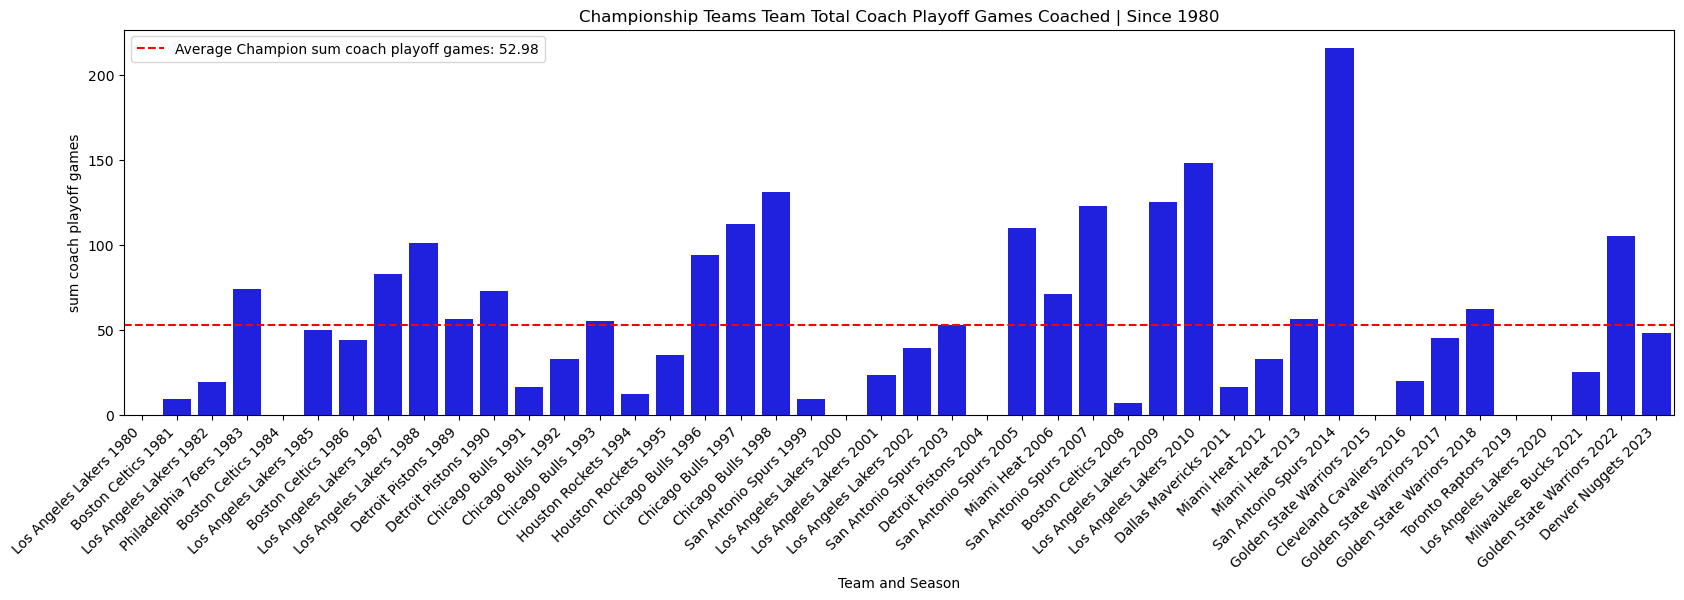

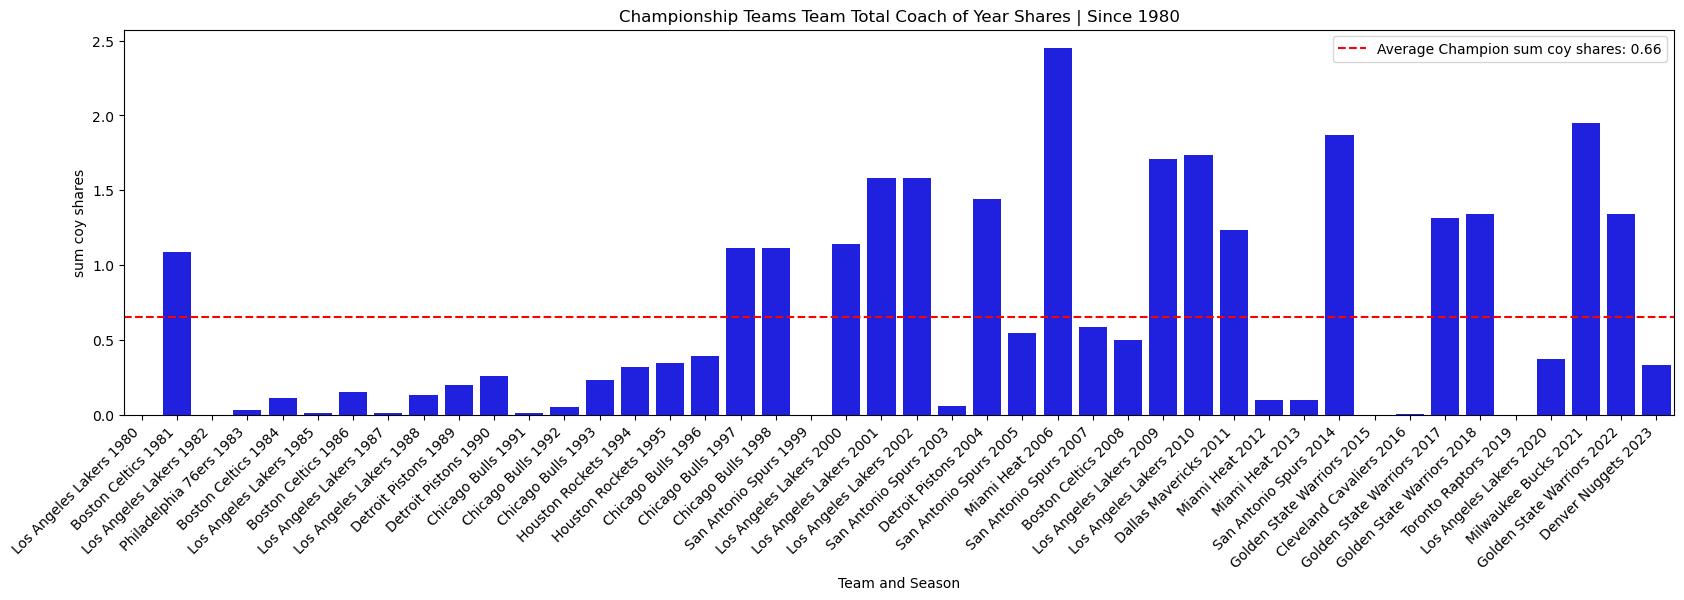

In [105]:
#df = pd.read_csv("NBA Champion LR Data.csv")
df = pd.read_csv("NBA Champion RawData.csv")
df.drop(df[df['Season'] < 1980].index, inplace = True)


champion_sea = df.loc[df['champion share'] == 1].copy()  

champion_sea.sort_values(by='Season', inplace=True)

champion_sea['Season'] = champion_sea['Season'].astype(str)

champion_sea['team_season'] = champion_sea['Team'] + ' ' + champion_sea['Season']

plt.figure(figsize=(20, 5))
plt.title("Championship Teams Team Total Coach Playoff Games Coached | Since 1980")

sns.barplot(x=champion_sea['team_season'], y=champion_sea['sum coach playoff games'], color='blue')

average_mvp = champion_sea['sum coach playoff games'].mean()

plt.axhline(y=average_mvp, color='r', linestyle='--', label=f'Average Champion sum coach playoff games: {average_mvp:.2f}')

plt.xlabel('Team and Season')
plt.ylabel('sum coach playoff games')
plt.xticks(rotation=45, ha='right')
plt.legend().set_visible(True)

plt.savefig("NBA_CPG_chps", bbox_inches='tight', pad_inches=0.1)
image = Image.open("NBA_CPG_chps.png")
image_with_border = ImageOps.expand(image, border=2, fill='black')
image_with_border.save("NBA_CPG_chps.png")

plt.show()

#==========================================================================================================================================================================================#

#df = pd.read_csv("NBA Champion LR Data.csv")
df = pd.read_csv("NBA Champion RawData.csv")
df.drop(df[df['Season'] < 1980].index, inplace = True)


champion_sea = df.loc[df['champion share'] == 1].copy()  

champion_sea.sort_values(by='Season', inplace=True)

champion_sea['Season'] = champion_sea['Season'].astype(str)

champion_sea['team_season'] = champion_sea['Team'] + ' ' + champion_sea['Season']

plt.figure(figsize=(20, 5))
plt.title("Championship Teams Team Total Coach of Year Shares | Since 1980")

sns.barplot(x=champion_sea['team_season'], y=champion_sea['sum coy shares'], color='blue')

average_mvp = champion_sea['sum coy shares'].mean()

plt.axhline(y=average_mvp, color='r', linestyle='--', label=f'Average Champion sum coy shares: {average_mvp:.2f}')

plt.xlabel('Team and Season')
plt.ylabel('sum coy shares')
plt.xticks(rotation=45, ha='right')
plt.legend().set_visible(True)

plt.savefig("NBA_coy_chps", bbox_inches='tight', pad_inches=0.1)
image = Image.open("NBA_coy_chps.png")
image_with_border = ImageOps.expand(image, border=2, fill='black')
image_with_border.save("NBA_coy_chps.png")

plt.show()

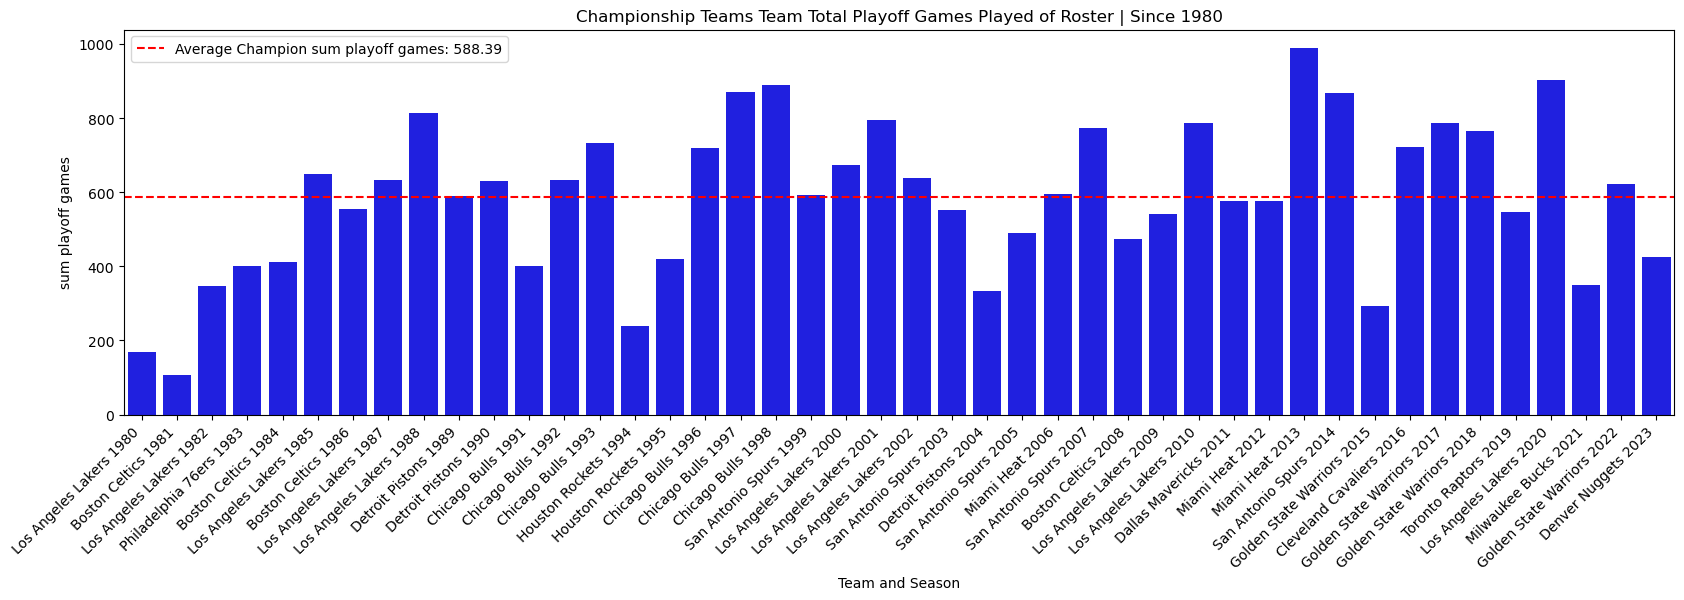

In [81]:
#df = pd.read_csv("NBA Champion LR Data.csv")
df = pd.read_csv("NBA Champion RawData.csv")
df.drop(df[df['Season'] < 1980].index, inplace = True)


champion_sea = df.loc[df['champion share'] == 1].copy()  

champion_sea.sort_values(by='Season', inplace=True)

champion_sea['Season'] = champion_sea['Season'].astype(str)

champion_sea['team_season'] = champion_sea['Team'] + ' ' + champion_sea['Season']

plt.figure(figsize=(20, 5))
plt.title("Championship Teams Team Total Playoff Games Played of Roster | Since 1980")

sns.barplot(x=champion_sea['team_season'], y=champion_sea['sum playoff games'], color='blue')

average_mvp = champion_sea['sum playoff games'].mean()

plt.axhline(y=average_mvp, color='r', linestyle='--', label=f'Average Champion sum playoff games: {average_mvp:.2f}')

plt.xlabel('Team and Season')
plt.ylabel('sum playoff games')
plt.xticks(rotation=45, ha='right')
plt.legend().set_visible(True)

plt.savefig("NBA_spg_chps", bbox_inches='tight', pad_inches=0.1)
image = Image.open("NBA_spg_chps.png")
image_with_border = ImageOps.expand(image, border=2, fill='black')
image_with_border.save("NBA_spg_chps.png")

plt.show()

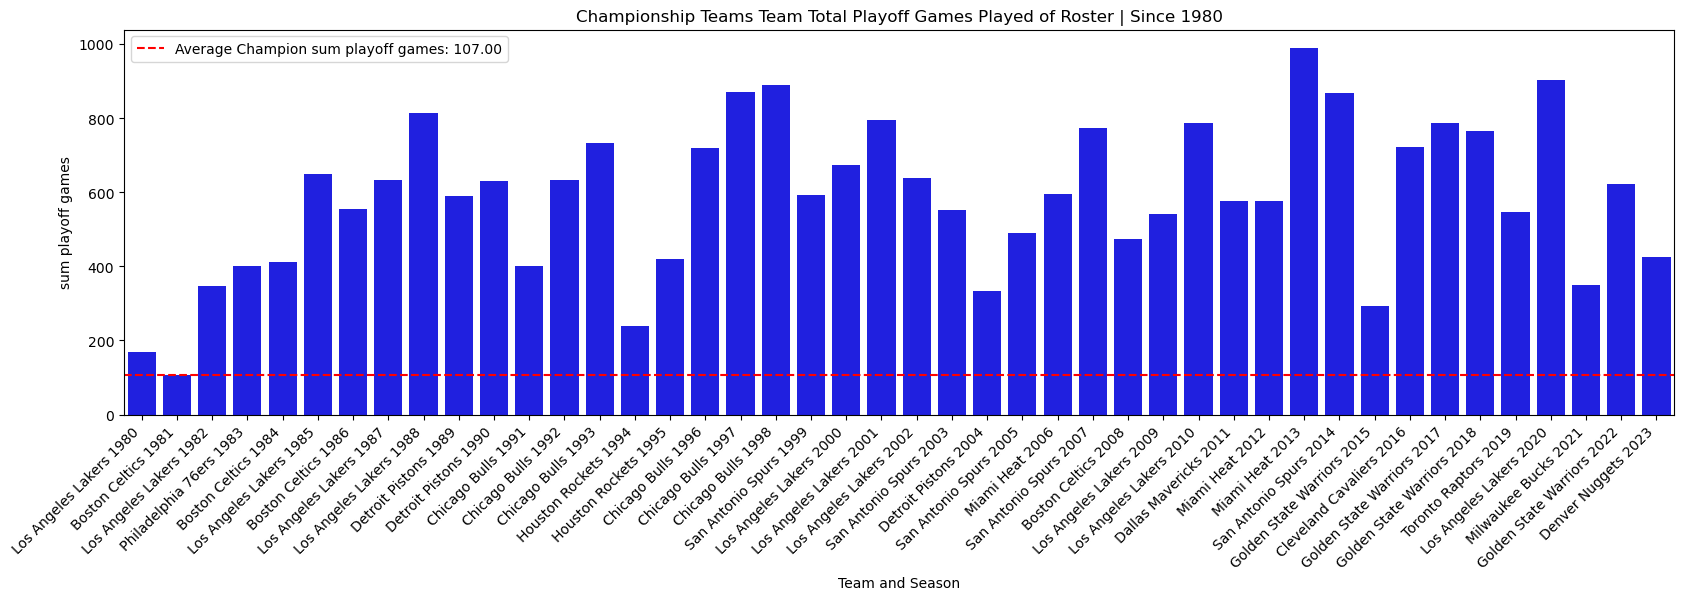

In [10]:
#df = pd.read_csv("NBA Champion LR Data.csv")
df = pd.read_csv("NBA Champion RawData.csv")
df.drop(df[df['Season'] < 1980].index, inplace = True)


champion_sea = df.loc[df['champion share'] == 1].copy()  

champion_sea.sort_values(by='Season', inplace=True)

champion_sea['Season'] = champion_sea['Season'].astype(str)

champion_sea['team_season'] = champion_sea['Team'] + ' ' + champion_sea['Season']

plt.figure(figsize=(20, 5))
plt.title("Championship Teams Team Total Playoff Games Played of Roster | Since 1980")

sns.barplot(x=champion_sea['team_season'], y=champion_sea['sum playoff games'], color='blue')

average_mvp = champion_sea['sum playoff games'].min()

plt.axhline(y=average_mvp, color='r', linestyle='--', label=f'Average Champion sum playoff games: {average_mvp:.2f}')

plt.xlabel('Team and Season')
plt.ylabel('sum playoff games')
plt.xticks(rotation=45, ha='right')
plt.legend().set_visible(True)

#plt.savefig("NBA_spg_min_chps", bbox_inches='tight', pad_inches=0.1)
#image = Image.open("NBA_spg_min_chps.png")
#image_with_border = ImageOps.expand(image, border=2, fill='black')
#image_with_border.save("NBA_spg_min_chps.png")

plt.show()

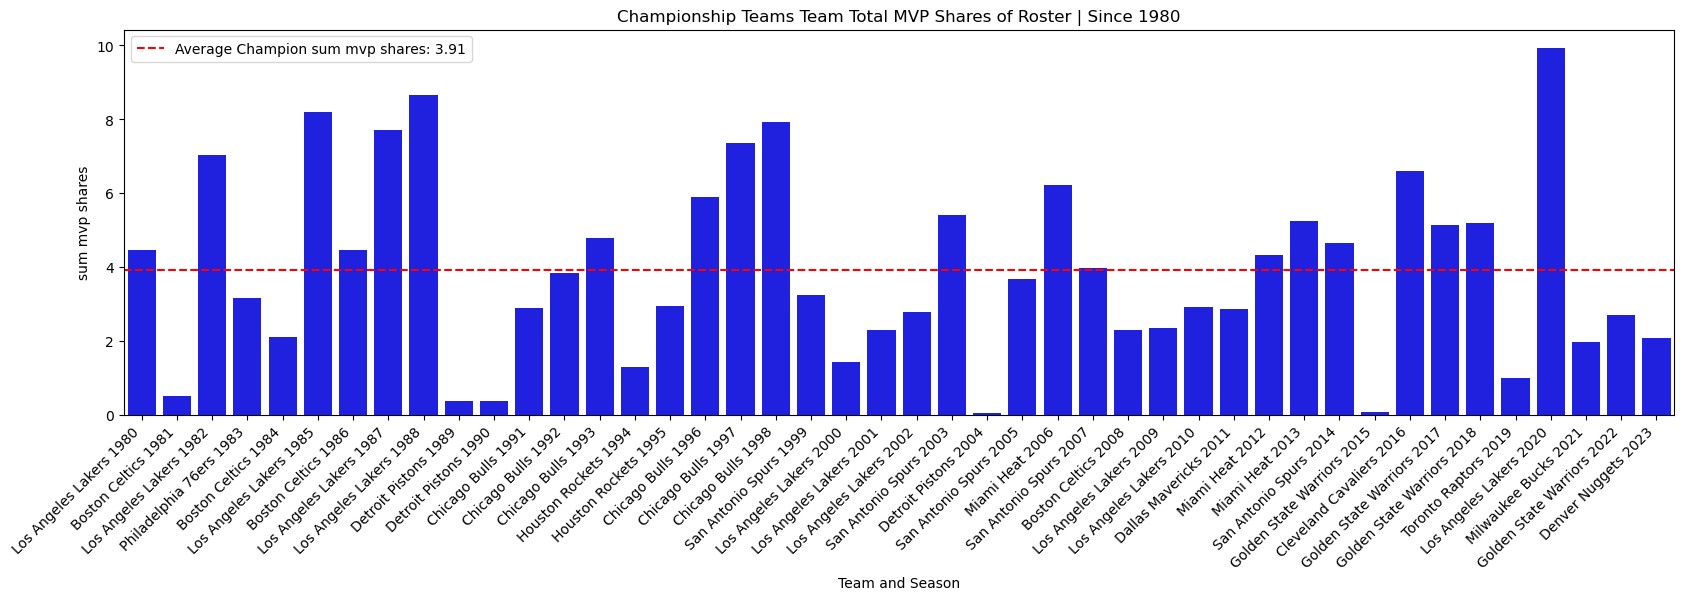

In [82]:
#df = pd.read_csv("NBA Champion LR Data.csv")
df = pd.read_csv("NBA Champion RawData.csv")
df.drop(df[df['Season'] < 1980].index, inplace = True)


champion_sea = df.loc[df['champion share'] == 1].copy()  

champion_sea.sort_values(by='Season', inplace=True)

champion_sea['Season'] = champion_sea['Season'].astype(str)

champion_sea['team_season'] = champion_sea['Team'] + ' ' + champion_sea['Season']

plt.figure(figsize=(20, 5))
plt.title("Championship Teams Team Total MVP Shares of Roster | Since 1980")

sns.barplot(x=champion_sea['team_season'], y=champion_sea['sum mvp shares'], color='blue')

average_mvp = champion_sea['sum mvp shares'].mean()

plt.axhline(y=average_mvp, color='r', linestyle='--', label=f'Average Champion sum mvp shares: {average_mvp:.2f}')

plt.xlabel('Team and Season')
plt.ylabel('sum mvp shares')
plt.xticks(rotation=45, ha='right')
plt.legend().set_visible(True)

#plt.savefig("NBA_sms_chps", bbox_inches='tight', pad_inches=0.1)
#image = Image.open("NBA_sms_chps.png")
#image_with_border = ImageOps.expand(image, border=2, fill='black')
#image_with_border.save("NBA_sms_chps.png")

plt.show()

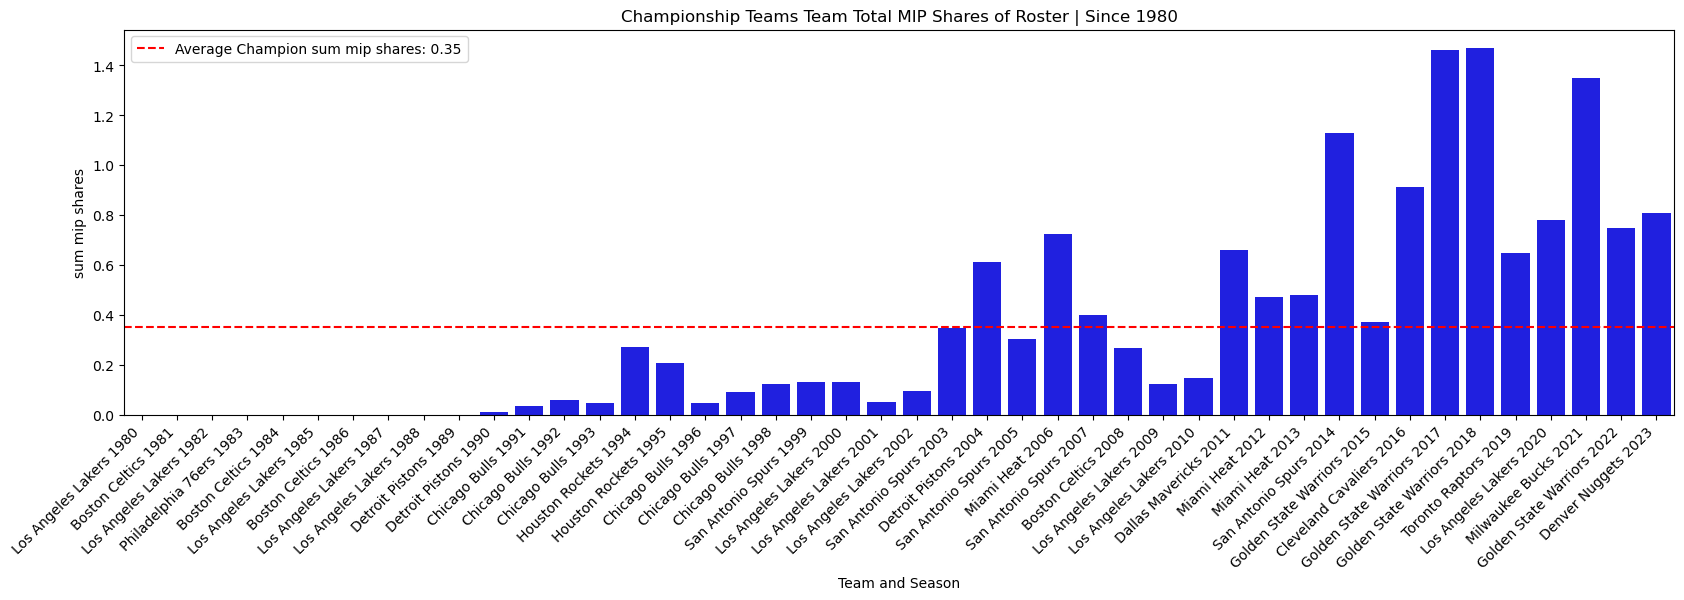

In [36]:
#df = pd.read_csv("NBA Champion LR Data.csv")
df = pd.read_csv("NBA Champion RawData.csv")
df.drop(df[df['Season'] < 1980].index, inplace = True)


champion_sea = df.loc[df['champion share'] == 1].copy()  

champion_sea.sort_values(by='Season', inplace=True)

champion_sea['Season'] = champion_sea['Season'].astype(str)

champion_sea['team_season'] = champion_sea['Team'] + ' ' + champion_sea['Season']

plt.figure(figsize=(20, 5))
plt.title("Championship Teams Team Total MIP Shares of Roster | Since 1980")

sns.barplot(x=champion_sea['team_season'], y=champion_sea['sum mip shares'], color='blue')

average_mvp = champion_sea['sum mip shares'].mean()

plt.axhline(y=average_mvp, color='r', linestyle='--', label=f'Average Champion sum mip shares: {average_mvp:.2f}')

plt.xlabel('Team and Season')
plt.ylabel('sum mip shares')
plt.xticks(rotation=45, ha='right')
plt.legend().set_visible(True)

#plt.savefig("NBA_sms_chps", bbox_inches='tight', pad_inches=0.1)
#image = Image.open("NBA_sms_chps.png")
#image_with_border = ImageOps.expand(image, border=2, fill='black')
#image_with_border.save("NBA_sms_chps.png")

plt.show()

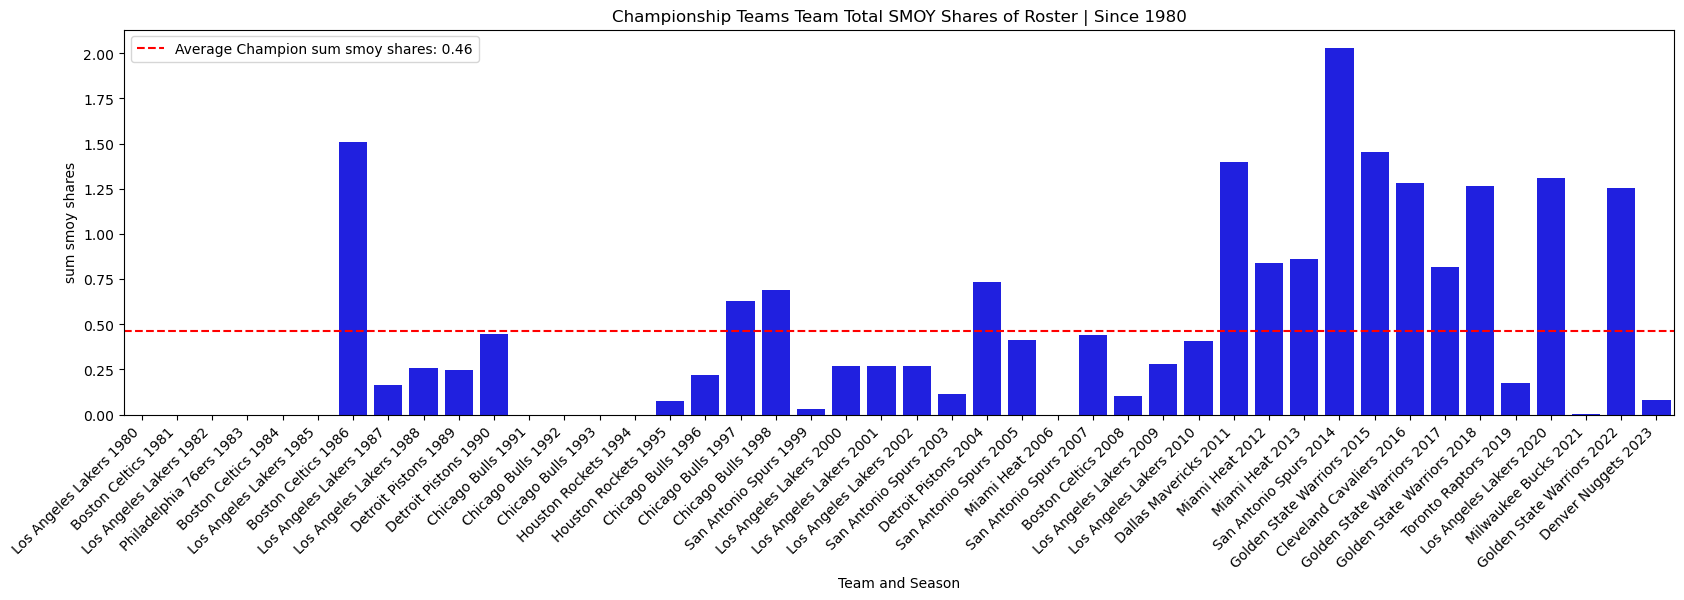

In [37]:
#df = pd.read_csv("NBA Champion LR Data.csv")
df = pd.read_csv("NBA Champion RawData.csv")
df.drop(df[df['Season'] < 1980].index, inplace = True)


champion_sea = df.loc[df['champion share'] == 1].copy()  

champion_sea.sort_values(by='Season', inplace=True)

champion_sea['Season'] = champion_sea['Season'].astype(str)

champion_sea['team_season'] = champion_sea['Team'] + ' ' + champion_sea['Season']

plt.figure(figsize=(20, 5))
plt.title("Championship Teams Team Total SMOY Shares of Roster | Since 1980")

sns.barplot(x=champion_sea['team_season'], y=champion_sea['sum smoy shares'], color='blue')

average_mvp = champion_sea['sum smoy shares'].mean()

plt.axhline(y=average_mvp, color='r', linestyle='--', label=f'Average Champion sum smoy shares: {average_mvp:.2f}')

plt.xlabel('Team and Season')
plt.ylabel('sum smoy shares')
plt.xticks(rotation=45, ha='right')
plt.legend().set_visible(True)

#plt.savefig("NBA_sms_chps", bbox_inches='tight', pad_inches=0.1)
#image = Image.open("NBA_sms_chps.png")
#image_with_border = ImageOps.expand(image, border=2, fill='black')
#image_with_border.save("NBA_sms_chps.png")

plt.show()

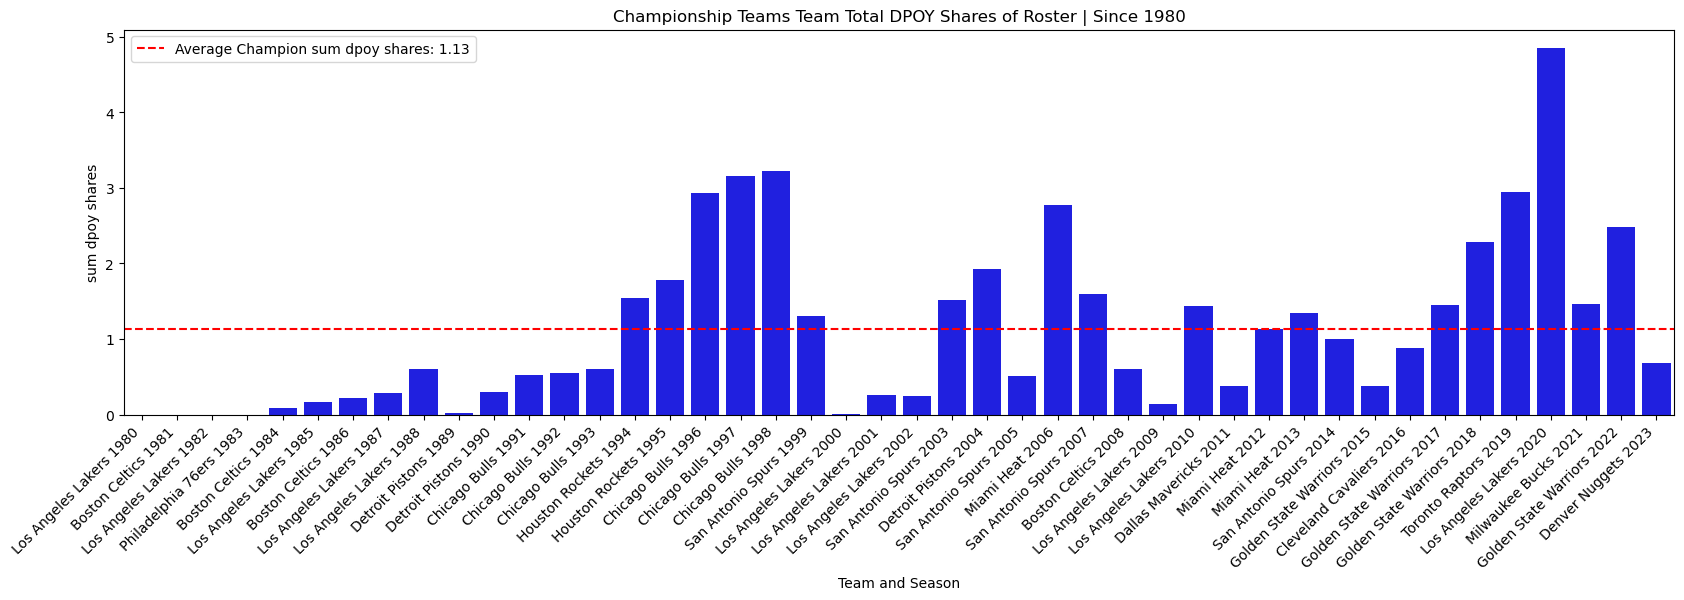

In [92]:
#df = pd.read_csv("NBA Champion LR Data.csv")
df = pd.read_csv("NBA Champion RawData.csv")
df.drop(df[df['Season'] < 1980].index, inplace = True)


champion_sea = df.loc[df['champion share'] == 1].copy()  

champion_sea.sort_values(by='Season', inplace=True)

champion_sea['Season'] = champion_sea['Season'].astype(str)

champion_sea['team_season'] = champion_sea['Team'] + ' ' + champion_sea['Season']

plt.figure(figsize=(20, 5))
plt.title("Championship Teams Team Total DPOY Shares of Roster | Since 1980")

sns.barplot(x=champion_sea['team_season'], y=champion_sea['sum dpoy shares'], color='blue')

average_mvp = champion_sea['sum dpoy shares'].mean()

plt.axhline(y=average_mvp, color='r', linestyle='--', label=f'Average Champion sum dpoy shares: {average_mvp:.2f}')

plt.xlabel('Team and Season')
plt.ylabel('sum dpoy shares')
plt.xticks(rotation=45, ha='right')
plt.legend().set_visible(True)

#plt.savefig("NBA_sms_chps", bbox_inches='tight', pad_inches=0.1)
#image = Image.open("NBA_sms_chps.png")
#image_with_border = ImageOps.expand(image, border=2, fill='black')
#image_with_border.save("NBA_sms_chps.png")

plt.show()

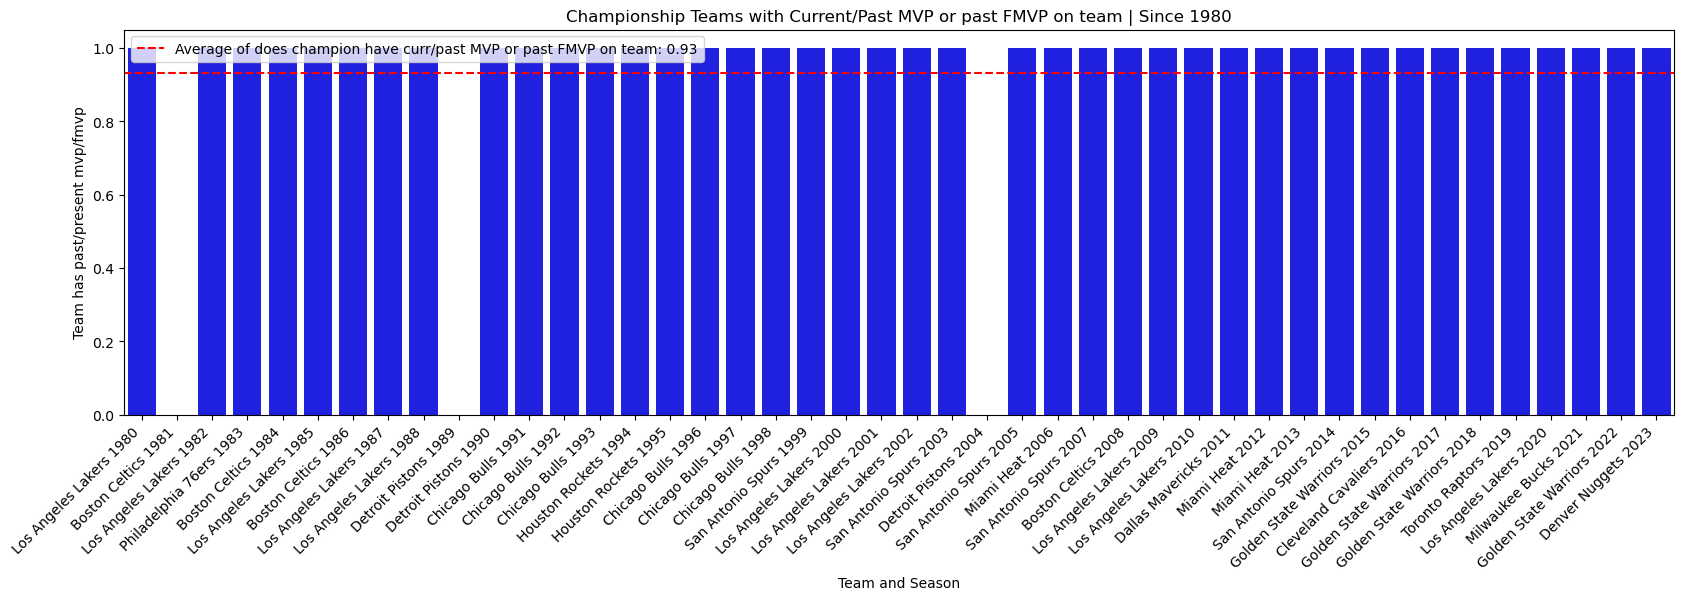

In [83]:
champion_sea = df.loc[df['champion share'] == 1].copy()  

champion_sea.sort_values(by='Season', inplace=True)

champion_sea['Season'] = champion_sea['Season'].astype(str)

champion_sea['team_season'] = champion_sea['Team'] + ' ' + champion_sea['Season']

plt.figure(figsize=(20, 5))
plt.title("Championship Teams with Current/Past MVP or past FMVP on team | Since 1980")

sns.barplot(x=champion_sea['team_season'], y=champion_sea['curr/past mvp or past fmvp'], color='blue')

average_mvp = champion_sea['curr/past mvp or past fmvp'].mean()

plt.axhline(y=average_mvp, color='r', linestyle='--', label=f'Average of does champion have curr/past MVP or past FMVP on team: {average_mvp:.2f}')

plt.xlabel('Team and Season')
plt.ylabel('Team has past/present mvp/fmvp')
plt.xticks(rotation=45, ha='right')
plt.legend().set_visible(True)

plt.savefig("NBA_CP-MVP_Pt_FMVP_chps", bbox_inches='tight', pad_inches=0.1)
image = Image.open("NBA_CP-MVP_Pt_FMVP_chps.png")
image_with_border = ImageOps.expand(image, border=2, fill='black')
image_with_border.save("NBA_CP-MVP_Pt_FMVP_chps.png")

plt.show()

## NBA Champion Must have Past/Present MVP or past FMVP on team to Win the Championship
- 41/44 NBA Champions since 1980 meet this rule.

In [84]:
mvp_counts = df[df['champion share'] == 1]['curr/past mvp or past fmvp'].value_counts()
champion_counts = df['champion'].value_counts()

# Display the counts
print("Count of NBA Champions with curr/past mvp or past fmvp on Team:")
print(mvp_counts)
print("\n")
print("curr/past mvp or past fmvp on Team Champion %: ", mvp_counts / champion_counts)

Count of NBA Champions with curr/past mvp or past fmvp on Team:
curr/past mvp or past fmvp
1    41
0     3
Name: count, dtype: int64


curr/past mvp or past fmvp on Team Champion %:  0    0.002542
1    0.931818
Name: count, dtype: float64


In [44]:
df = pd.read_csv("NBA Champion LR Data.csv")
print(list(df.columns))

['Season', 'Team/Season', 'Team', 'Team ID', 'Team ID/Season', 'Conference', 'Conference/Season', 'Conference 5=> rec', 'Conference OR', 'Conference SRS', 'Conference Age', 'pre playoff odds', 'pre playoff odds rank', 'pre season odds', 'champion', 'champion share', 'make playoffs', 'top 3 conference', 'rk conference', 'overall record', 'over500 rec', 'over600 rec', '20 =< wins', '5 => rec', 'sum coach playoff games', 'sum coy shares', 'sum playoff games', 'sum champion', 'sum champion share', 'sum mvp shares', 'sum all defense', 'sum all nba', 'sum dpoy shares', 'sum smoy shares', 'sum mip shares', 'sum all stars', 'sum player L1Y cs', 'sum player L3Y cs', 'sum player L5Y cs', 'sum player L8Y cs', 'sum player L10Y cs', 'sum L3Y mvp shares ', 'sum L5Y  mvp shares', 'sum franchise L1Y cs', 'sum franchise L3Y cs', 'sum franchise L5Y cs', 'sum franchise L8Y cs', 'sum franchise L10Y cs', 'team_rating_custom', 'max_player_rating_custom', 'curr/past mvp or past fmvp', 'FG', 'FGA', 'FG%', '3P

Column Averages:
pre playoff odds rank         2.204545
Offense Four Factors|eFG%     4.750000
top 3 conference              0.977273
over500 rec                   2.681818
sum playoff games             4.500000
over600 rec                   3.500000
MOV                           2.977273
SRS                           2.977273
team_rating_custom            2.954545
max_player_rating_custom      3.750000
pre season odds               2.386364
2P%                           4.636364
ORB                          15.159091
sum player L3Y cs             5.477273
20 =< wins                    4.636364
sum mvp shares                3.454545
sum player L8Y cs             6.204545
2P                            9.863636
sum all nba                   4.204545
FT                           16.409091
AST                           7.863636
SOS                          19.545455
DRtg                          5.454545
sum franchise L1Y cs          4.590909
5 => rec                      6.840909
Conferen

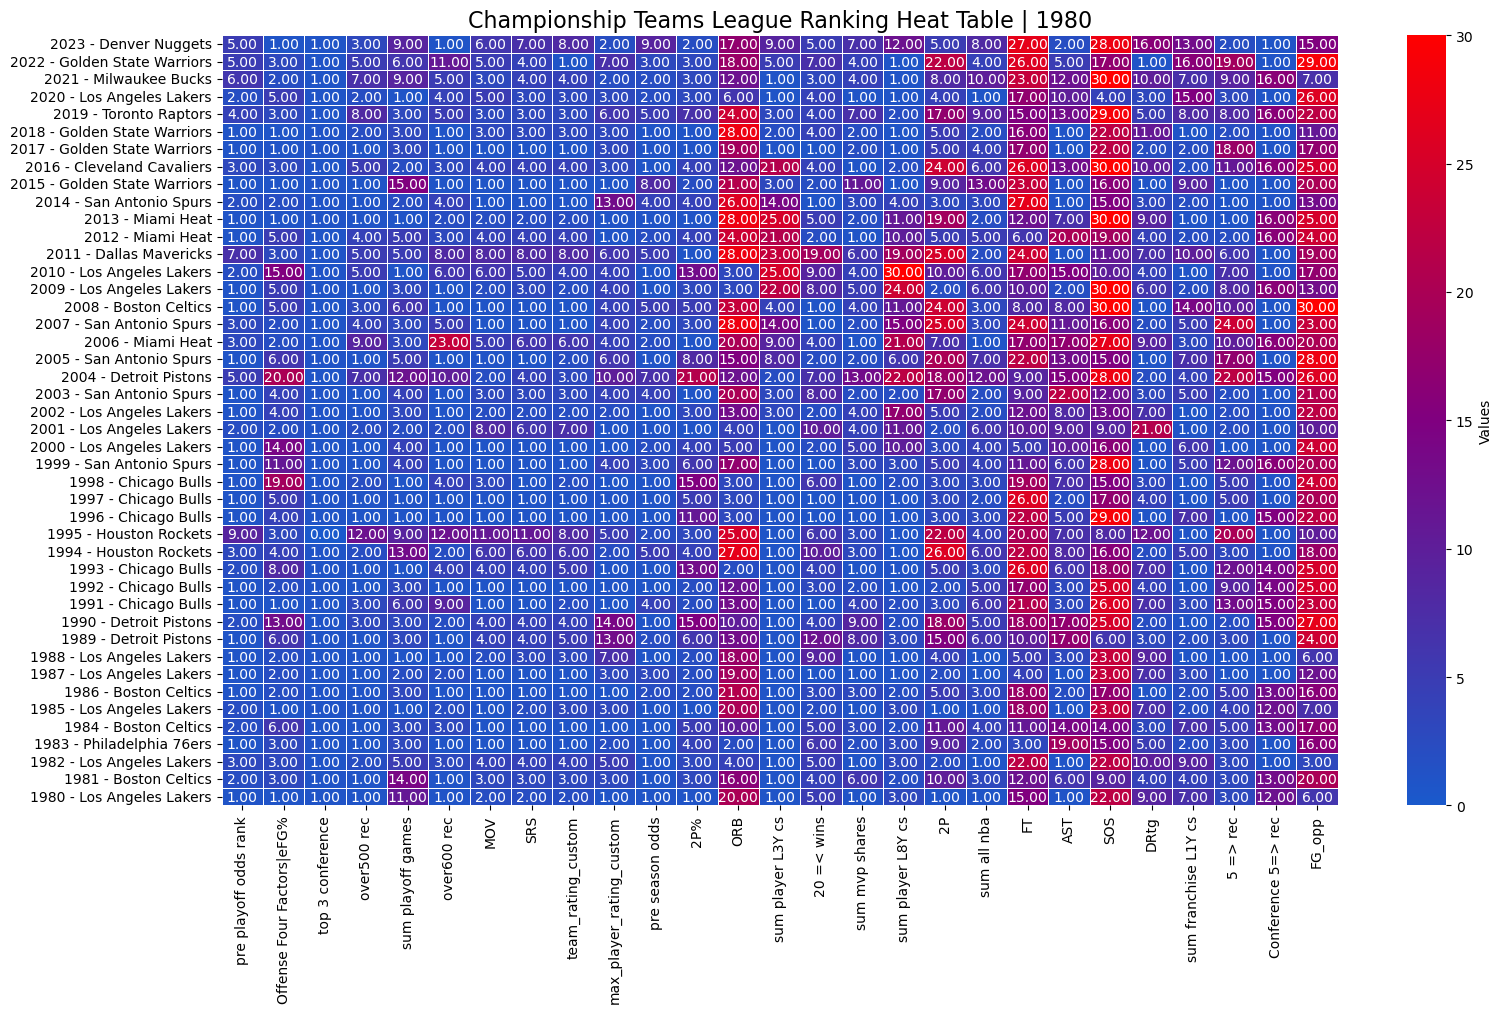

In [36]:
from matplotlib.colors import ListedColormap
df = pd.read_csv("NBA Champion LR Data.csv")
#df = pd.read_csv("NBA Champion RawData.csv")
df.drop(df[df['Season'] < 1980].index, inplace = True)


champions_only = df[df['champion share'] == 1]

custom_palette = sns.color_palette("pastel", as_cmap=True)

large_color = 'red'  
middle_color = 'purple'
small_color = (0.1, 0.35, .8)

large_threshold = 1.5  
middle_threshold = 0.5 

colors = sns.color_palette([small_color, middle_color, large_color], as_cmap=True)
custom_cmap = sns.blend_palette(colors, as_cmap=True)

plt.figure(figsize=(18, 10))
heatmap_data = champions_only[['pre playoff odds rank','Offense Four Factors|eFG%','top 3 conference','over500 rec','sum playoff games' ,'over600 rec','MOV', 'SRS','team_rating_custom', 'max_player_rating_custom', 'pre season odds', '2P%', 'ORB', 'sum player L3Y cs', '20 =< wins', 'sum mvp shares', 'sum player L8Y cs', '2P', 'sum all nba', 'FT', 'AST', 'SOS', 'DRtg', 'sum franchise L1Y cs', '5 => rec', 'Conference 5=> rec', 'FG_opp']]

heatmap = sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap=custom_cmap, linewidths=.5, cbar_kws={'label': 'Values'}, vmin=heatmap_data.min().min(), vmax=heatmap_data.max().max())

championship_teams_labels = ['{} - {}'.format(season, team) for season, team in zip(champions_only['Season'], champions_only['Team'])]
plt.yticks(ticks=[i + 0.5 for i in range(len(championship_teams_labels))], labels=championship_teams_labels, rotation=0)

column_averages = heatmap_data.mean()
print("Column Averages:")
print(column_averages)

plt.title('Championship Teams League Ranking Heat Table | 1980', fontsize=16)
#plt.savefig("ht_allChamps_fea_table.png", bbox_inches='tight', pad_inches=0.1)
#image = Image.open("ht_allChamps_fea_table.png")
#image_with_border = ImageOps.expand(image, border=2, fill='black')
#image_with_border.save("ht_allChamps_fea_table.png")

plt.show()

## Analyzing the Non-Star Champions

<Figure size 100x100 with 0 Axes>

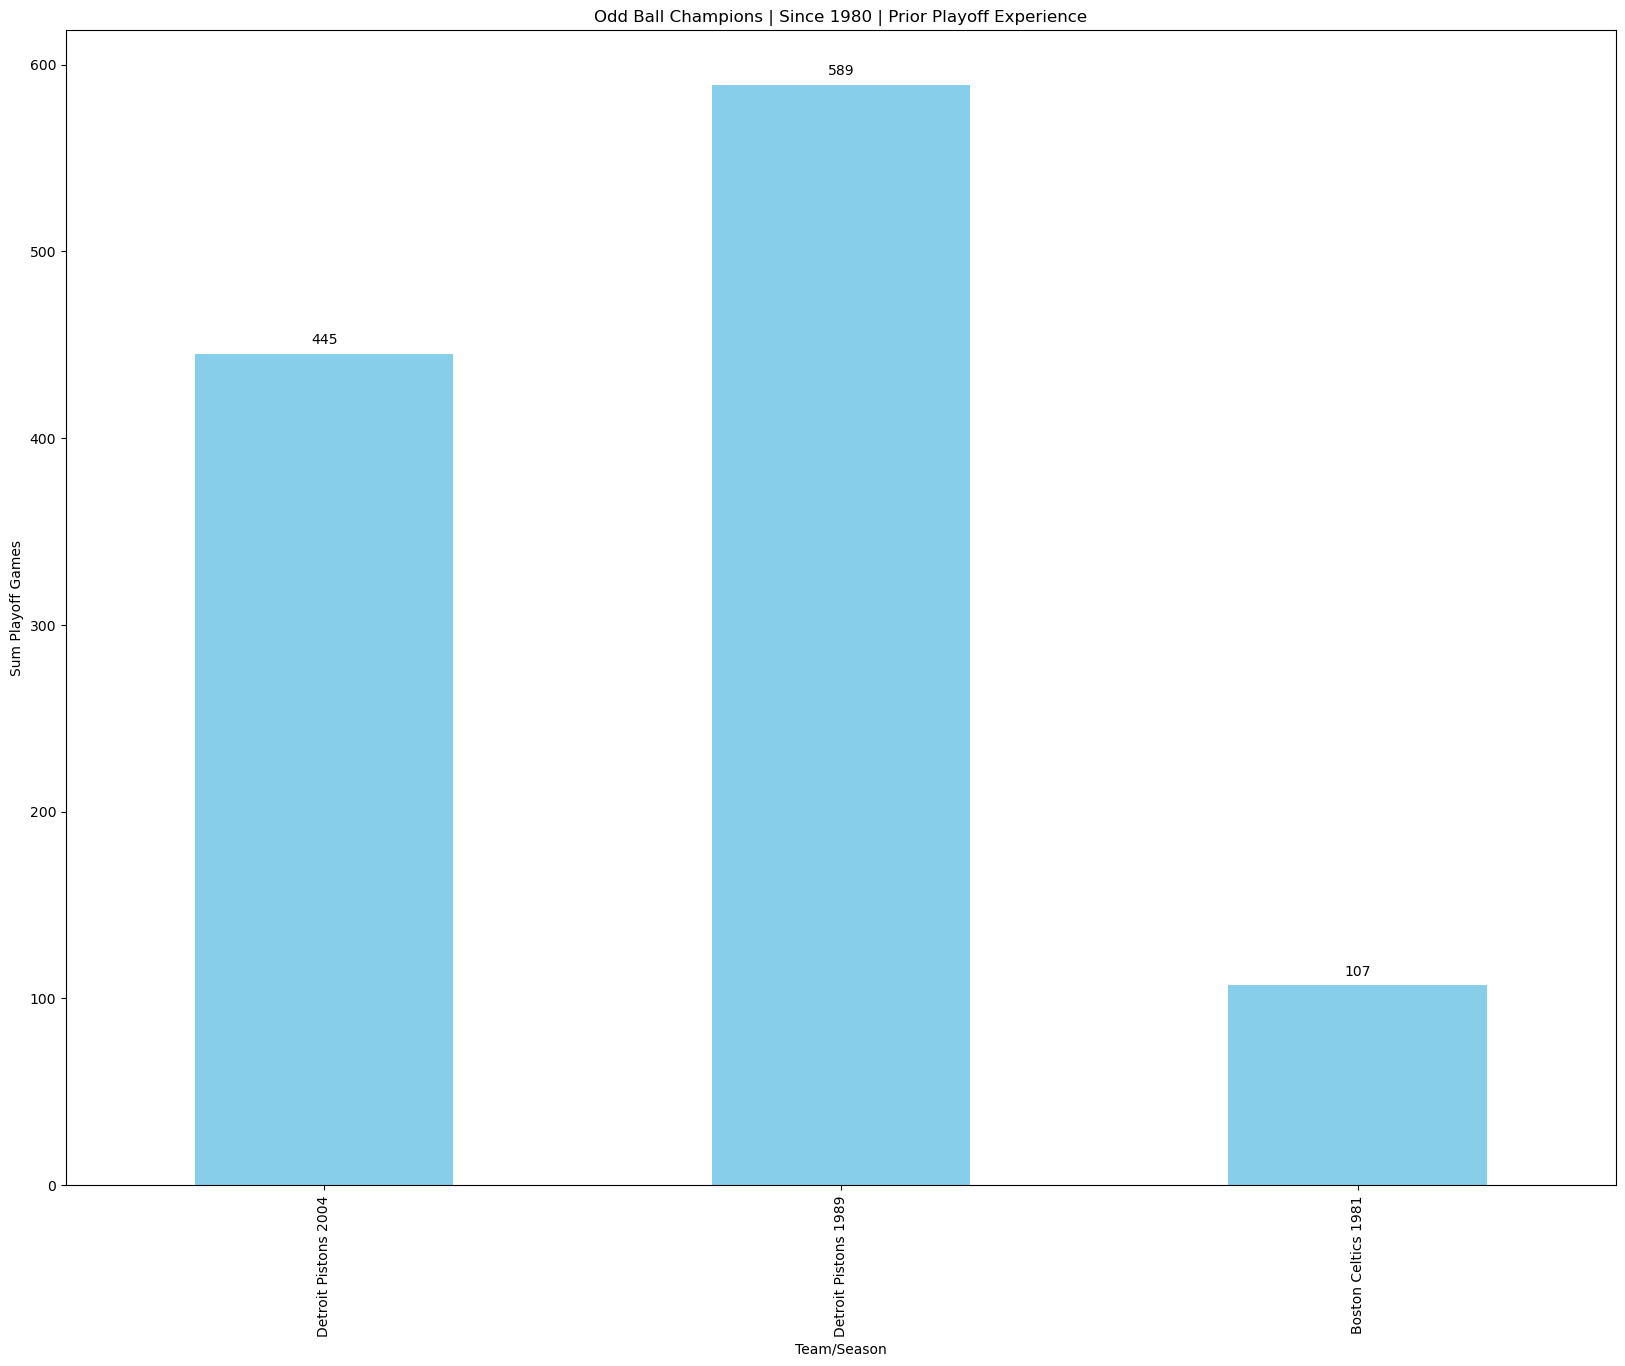

In [63]:
df = pd.read_csv("NBA Champion RawData.csv")
plt.figure(figsize=(1, 1))

teams_seasons = ['Boston Celtics 1981', 'Detroit Pistons 1989', 'Detroit Pistons 2004']
filtered_data = df[df['Team/Season'].isin(teams_seasons)]

ax = filtered_data.plot(kind='bar', x='Team/Season', y='sum playoff games', color='skyblue', legend=False)
plt.title('Odd Ball Champions | Since 1980 | Prior Playoff Experience')
plt.xlabel('Team/Season')
plt.ylabel('Sum Playoff Games')

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

In [64]:
df = pd.read_csv("NBA Champion RawData.csv")

desired_seasons = [2004, 1989, 1981]

for season in desired_seasons:
    filtered_data = df[df['Season'] == season]
    average_playoff_games = filtered_data['sum playoff games'].mean()
    print(f"{season}: {average_playoff_games:.2f}")

2004: 327.93
1989: 271.32
1981: 172.57


In [15]:
print(list(df.columns))

['Season', 'Team/Season', 'Team', 'Team ID', 'Team ID/Season', 'Conference', 'Conference/Season', 'Conference 5=> rec', 'Conference OR', 'Conference SRS', 'Conference Age', 'pre playoff odds', 'pre playoff odds rank', 'pre season odds', 'champion', 'champion share', 'make playoffs', 'top 3 conference', 'rk conference', 'overall record', 'over500 rec', 'over600 rec', '20 =< wins', '5 => rec', 'sum coach playoff games', 'sum coy shares', 'sum playoff games', 'sum champion', 'sum champion share', 'sum mvp shares', 'sum all defense', 'sum all nba', 'sum dpoy shares', 'sum smoy shares', 'sum mip shares', 'sum all stars', 'sum player L1Y cs', 'sum player L3Y cs', 'sum player L5Y cs', 'sum player L8Y cs', 'sum player L10Y cs', 'sum L3Y mvp shares ', 'sum L5Y  mvp shares', 'sum franchise L1Y cs', 'sum franchise L3Y cs', 'sum franchise L5Y cs', 'sum franchise L8Y cs', 'sum franchise L10Y cs', 'team_rating_custom', 'max_player_rating_custom', 'curr/past mvp or past fmvp', 'FG', 'FGA', 'FG%', '3P

Column Averages:
Conference 5=> rec            9.666667
pre playoff odds             23.666667
pre playoff odds rank         2.666667
pre season odds               3.333333
top 3 conference              1.000000
team_rating_custom            3.666667
max_player_rating_custom      8.666667
FTr                           7.333333
PF                           18.000000
Age                           6.333333
overall record                2.666667
over500 rec                   3.000000
over600 rec                   4.000000
20 =< wins                    7.666667
5 => rec                      9.333333
sum coach playoff games       9.000000
sum coy shares                6.000000
sum playoff games             9.666667
sum champion                 13.333333
sum champion share            9.333333
2P%_opp                      23.666667
sum mvp shares                9.000000
sum all defense              13.333333
sum all nba                   7.000000
sum dpoy shares               5.666667
sum smoy

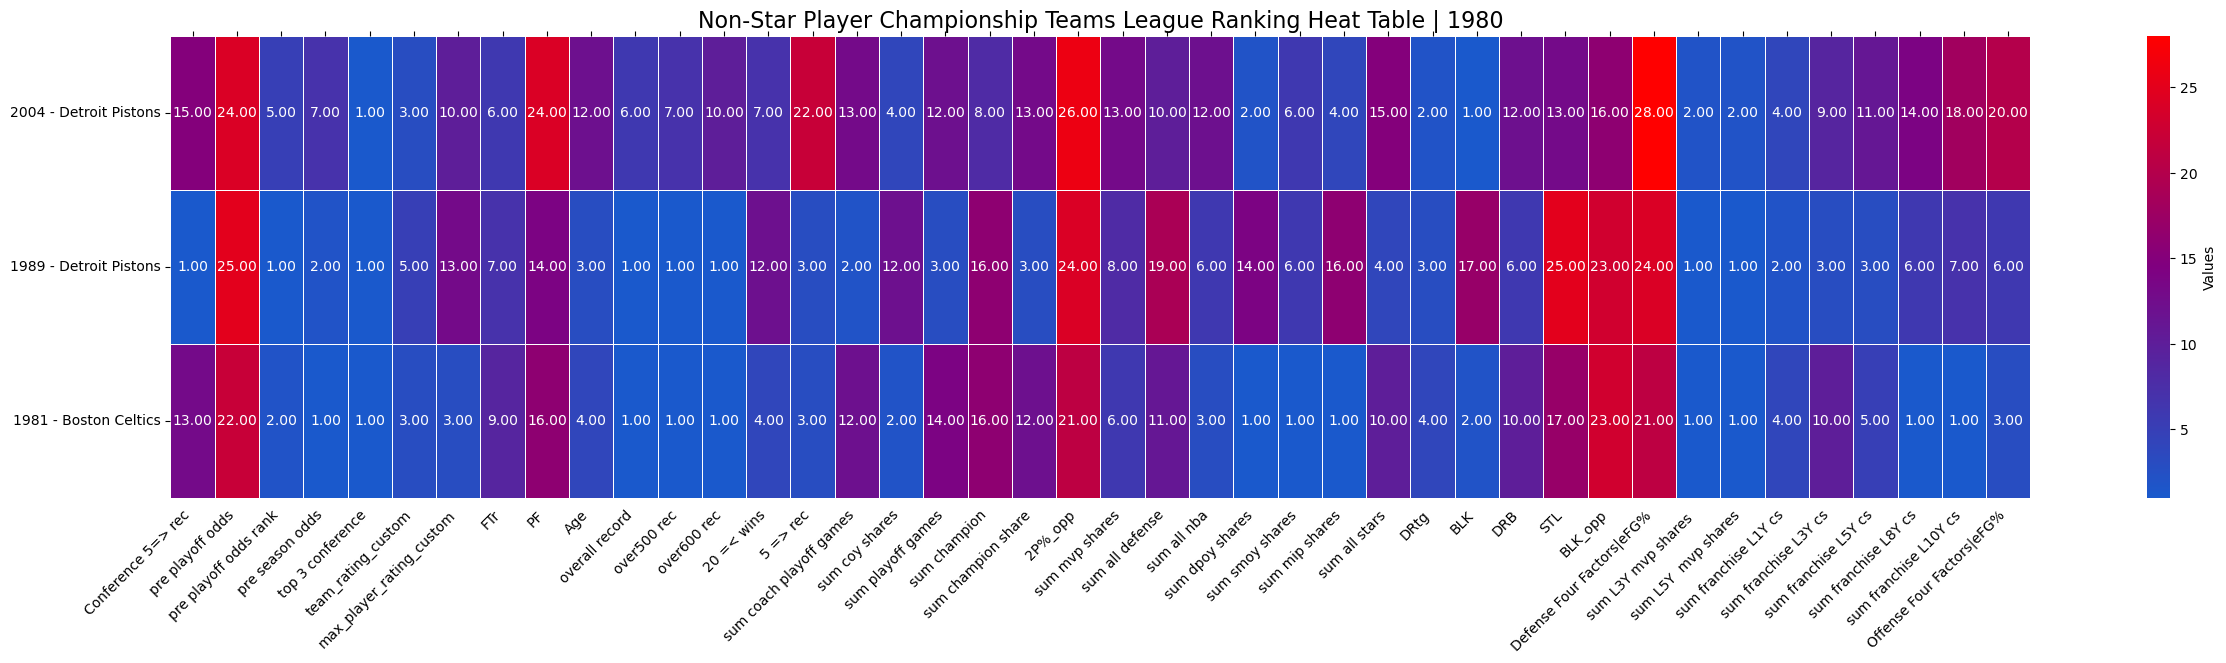

In [31]:
df = pd.read_csv("NBA Champion LR Data.csv")
#df = pd.read_csv("NBA Champion RawData.csv")

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image, ImageOps

teams_of_interest = ['Boston Celtics 1981', 'Detroit Pistons 1989', 'Detroit Pistons 2004']
champions_only = df[df['Team/Season'].isin(teams_of_interest)].copy()  

numeric_columns = ['Conference 5=> rec', 'pre playoff odds', 'pre playoff odds rank', 'pre season odds','top 3 conference', 'team_rating_custom','max_player_rating_custom','FTr','PF','Age',
                   'overall record', 'over500 rec', 'over600 rec', '20 =< wins', '5 => rec', 'sum coach playoff games', 'sum coy shares', 'sum playoff games', 'sum champion', 'sum champion share','2P%_opp',
                   'sum mvp shares', 'sum all defense', 'sum all nba', 'sum dpoy shares', 'sum smoy shares', 'sum mip shares', 'sum all stars', 'DRtg', 'BLK','DRB','STL','BLK_opp', 'Defense Four Factors|eFG%',
                  'sum L3Y mvp shares ', 'sum L5Y  mvp shares', 'sum franchise L1Y cs', 'sum franchise L3Y cs', 'sum franchise L5Y cs', 'sum franchise L8Y cs', 'sum franchise L10Y cs','Offense Four Factors|eFG%']


custom_palette = sns.color_palette("pastel", as_cmap=True)

large_color = 'red'
middle_color = 'purple'
small_color = (0.1, 0.35, 0.8)

large_threshold = 1.5
middle_threshold = 0.5

colors = sns.color_palette([small_color, middle_color, large_color], as_cmap=True)
custom_cmap = sns.blend_palette(colors, as_cmap=True)

plt.figure(figsize=(30, 6))
heatmap = sns.heatmap(
    champions_only[numeric_columns],
    annot=True,
    fmt=".2f",
    cmap=custom_cmap,
    linewidths=.5,
    cbar_kws={'label': 'Values'},
    vmin=champions_only[numeric_columns].min().min(),
    vmax=champions_only[numeric_columns].max().max()
)

championship_teams_labels = ['{} - {}'.format(season, team) for season, team in zip(champions_only['Season'], champions_only['Team'])]
plt.yticks(ticks=[i + 0.5 for i in range(len(championship_teams_labels))], labels=championship_teams_labels, rotation=0)

column_headers = numeric_columns
plt.xticks(ticks=[i + 0.5 for i in range(len(column_headers))], labels=column_headers, rotation=45, ha="right")

plt.tick_params(axis='x', which='both', bottom=False, top=True)

column_averages = champions_only[numeric_columns].mean()
print("Column Averages:")
print(column_averages)

plt.title('Non-Star Player Championship Teams League Ranking Heat Table | 1980', fontsize=16)
#plt.savefig("ht_champs_n_star.png", bbox_inches='tight', pad_inches=0.1)
#image = Image.open("ht_champs_n_star.png")
#image_with_border = ImageOps.expand(image, border=2, fill='black')
#image_with_border.save("ht_champs_n_star.png")
plt.show()

Column Averages:
Conference 5=> rec            0.500151
pre playoff odds            386.666667
pre playoff odds rank         2.666667
pre season odds             633.333333
top 3 conference              1.000000
team_rating_custom           31.961421
max_player_rating_custom     60.551452
overall record                0.727642
over500 rec                   0.648934
over600 rec                   0.573232
20 =< wins                    7.333333
5 => rec                      0.573828
sum coach playoff games      21.666667
sum coy shares                0.907667
sum playoff games           343.333333
sum champion                  0.333333
sum champion share           12.921230
sum mvp shares                0.300000
sum all defense               1.000000
sum all nba                   4.000000
sum dpoy shares               0.650000
sum smoy shares               0.325000
sum mip shares                0.204333
sum all stars                 7.333333
DRtg                        100.900000
BLK     

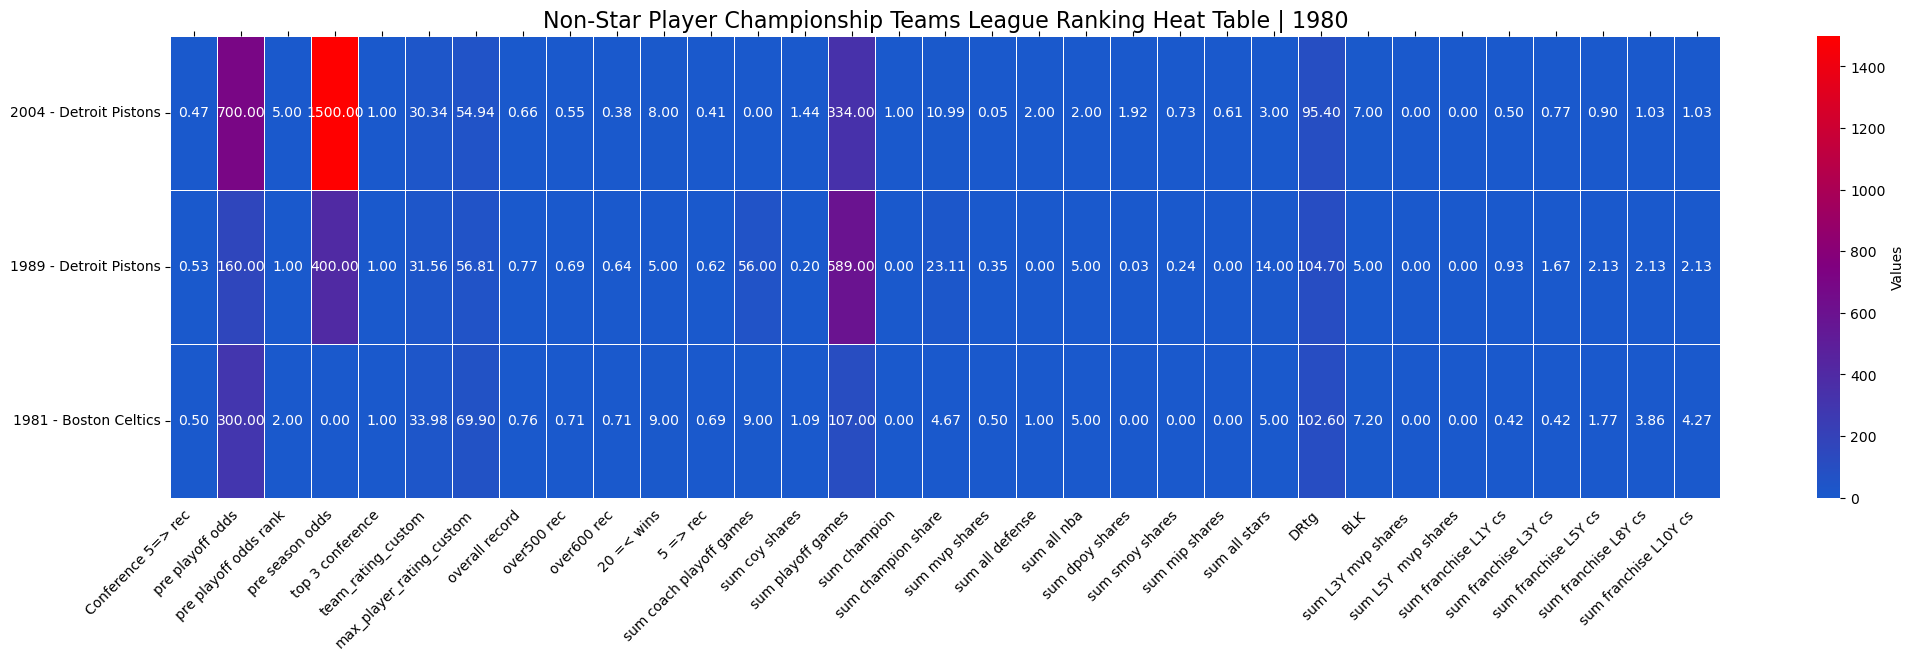

In [19]:
#df = pd.read_csv("NBA Champion LR Data.csv")
df = pd.read_csv("NBA Champion RawData.csv")

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image, ImageOps

teams_of_interest = ['Boston Celtics 1981', 'Detroit Pistons 1989', 'Detroit Pistons 2004']
champions_only = df[df['Team/Season'].isin(teams_of_interest)].copy()  

numeric_columns = ['Conference 5=> rec', 'pre playoff odds', 'pre playoff odds rank', 'pre season odds','top 3 conference', 'team_rating_custom','max_player_rating_custom',
                   'overall record', 'over500 rec', 'over600 rec', '20 =< wins', '5 => rec', 'sum coach playoff games', 'sum coy shares', 'sum playoff games', 'sum champion', 'sum champion share',
                   'sum mvp shares', 'sum all defense', 'sum all nba', 'sum dpoy shares', 'sum smoy shares', 'sum mip shares', 'sum all stars', 'DRtg', 'BLK',
                  'sum L3Y mvp shares ', 'sum L5Y  mvp shares', 'sum franchise L1Y cs', 'sum franchise L3Y cs', 'sum franchise L5Y cs', 'sum franchise L8Y cs', 'sum franchise L10Y cs']


custom_palette = sns.color_palette("pastel", as_cmap=True)

large_color = 'red'
middle_color = 'purple'
small_color = (0.1, 0.35, 0.8)

large_threshold = 1.5
middle_threshold = 0.5

colors = sns.color_palette([small_color, middle_color, large_color], as_cmap=True)
custom_cmap = sns.blend_palette(colors, as_cmap=True)

plt.figure(figsize=(25, 6))
heatmap = sns.heatmap(
    champions_only[numeric_columns],
    annot=True,
    fmt=".2f",
    cmap=custom_cmap,
    linewidths=.5,
    cbar_kws={'label': 'Values'},
    vmin=champions_only[numeric_columns].min().min(),
    vmax=champions_only[numeric_columns].max().max()
)

championship_teams_labels = ['{} - {}'.format(season, team) for season, team in zip(champions_only['Season'], champions_only['Team'])]
plt.yticks(ticks=[i + 0.5 for i in range(len(championship_teams_labels))], labels=championship_teams_labels, rotation=0)

column_headers = numeric_columns
plt.xticks(ticks=[i + 0.5 for i in range(len(column_headers))], labels=column_headers, rotation=45, ha="right")

plt.tick_params(axis='x', which='both', bottom=False, top=True)

column_averages = champions_only[numeric_columns].mean()
print("Column Averages:")
print(column_averages)

plt.title('Non-Star Player Championship Teams League Ranking Heat Table | 1980', fontsize=16)
plt.savefig("ht_champs_n_star_values.png", bbox_inches='tight', pad_inches=0.1)
image = Image.open("ht_champs_n_star_values.png")
image_with_border = ImageOps.expand(image, border=2, fill='black')
image_with_border.save("ht_champs_n_star_values.png")
plt.show()

### How did these These teams do it?
- The first that I noticed about these underdogs, is that they typical a top team in the league in over500 rec and vegas does recognize them as a contender.
- Secondly there defense. These 3 teams were all top 4 in the NBA in DRtg and 2004 pistons had a ton of dpoy shares.
- The have recent playoff experience. They at least have to more 6 playoff wins last season (6.72).
- Their coach is one of the most playoff experienced coaches in the league. All of these teams coaches ranked top 5 in league in playoff games experience.
- Besides the numbers. As a fan, I know that these teams played rough, really rough brand of basketball.

In [5]:
df = pd.read_csv("NBA Champion LR Data.csv")
print(list(df.columns))

['Season', 'Team/Season', 'Team', 'Team ID', 'Team ID/Season', 'Conference', 'Conference/Season', 'Conference 5=> rec', 'Conference OR', 'Conference SRS', 'Conference Age', 'pre playoff odds', 'pre playoff odds rank', 'pre season odds', 'champion', 'champion share', 'make playoffs', 'top 3 conference', 'rk conference', 'overall record', 'over500 rec', 'over600 rec', '20 =< wins', '5 => rec', 'sum coach playoff games', 'sum coy shares', 'sum playoff games', 'sum champion', 'sum champion share', 'sum mvp shares', 'sum all defense', 'sum all nba', 'sum dpoy shares', 'sum smoy shares', 'sum mip shares', 'sum all stars', 'sum player L1Y cs', 'sum player L3Y cs', 'sum player L5Y cs', 'sum player L8Y cs', 'sum player L10Y cs', 'sum L3Y mvp shares ', 'sum L5Y  mvp shares', 'sum franchise L1Y cs', 'sum franchise L3Y cs', 'sum franchise L5Y cs', 'sum franchise L8Y cs', 'sum franchise L10Y cs', 'team_rating_custom', 'max_player_rating_custom', 'curr/past mvp or past fmvp', 'FG', 'FGA', 'FG%', '3P

In [78]:
#df = pd.read_csv("NBA Champion LR Data.csv")
df = pd.read_csv("NBA Champion RawData.csv")
#print(list(df.columns))
df.drop(df[df['Season'] < 1980].index, inplace = True)
df = df[df['make playoffs']==1]

features = ['Conference 5=> rec', 'Conference OR', 'Conference SRS', 'Conference Age', 'pre playoff odds rank', 'pre season odds', 'top 3 conference', 'rk conference', 'overall record', 'over500 rec', 'over600 rec', '20 =< wins', '5 => rec', 'sum coach playoff games', 'sum coy shares', 'sum playoff games', 'sum champion', 'sum champion share', 'sum mvp shares', 'sum all defense', 'sum all nba', 'sum dpoy shares', 'sum smoy shares', 'sum mip shares', 'sum all stars', 'sum player L1Y cs', 'sum player L3Y cs', 'sum player L5Y cs', 'sum player L8Y cs', 'sum player L10Y cs', 'sum L3Y mvp shares ', 'sum L5Y  mvp shares', 'sum franchise L1Y cs', 'sum franchise L3Y cs', 'sum franchise L5Y cs', 'sum franchise L8Y cs', 'sum franchise L10Y cs', 'team_rating_custom', 'max_player_rating_custom', 'curr/past mvp or past fmvp', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'FG_opp', 'FGA_opp', 'FG%_opp', '3P_opp', '3PA_opp', '3P%_opp', '2P_opp', '2PA_opp', '2P%_opp', 'FT_opp', 'FTA_opp', 'FT%_opp', 'ORB_opp', 'DRB_opp', 'TRB_opp', 'AST_opp', 'STL_opp', 'BLK_opp', 'TOV_opp', 'PF_opp', 'PTS_opp', 'Age', 'W', 'L', 'PW', 'PL', 'MOV', 'SOS', 'SRS', 'ORtg', 'DRtg', 'NRtg', 'Pace', 'FTr', '3PAr', 'TS%', 'Offense Four Factors|eFG%', 'Offense Four Factors|TOV%', 'Offense Four Factors|ORB%', 'Offense Four Factors|FT/FGA', 'Defense Four Factors|eFG%', 'Defense Four Factors|TOV%', 'Defense Four Factors|DRB%', 'Defense Four Factors|FT/FGA']
target = ['champion share']

# Filtering the DataFrame based on selected features
selected_df = df[features + target]

# Calculating the correlation coefficients
correlation_coefficients = selected_df.corr()['champion share']

# Sorting the correlation coefficients in descending order
sorted_correlation = correlation_coefficients.sort_values(ascending=False)

# Printing the sorted correlation coefficients
print(sorted_correlation.head(20))

champion share                1.000000
overall record                0.648157
top 3 conference              0.637789
over500 rec                   0.615351
MOV                           0.599865
NRtg                          0.597188
W                             0.591735
SRS                           0.585720
team_rating_custom            0.577438
PW                            0.542156
over600 rec                   0.524610
max_player_rating_custom      0.462793
20 =< wins                    0.417604
sum franchise L1Y cs          0.383765
sum mvp shares                0.383098
curr/past mvp or past fmvp    0.380130
sum champion share            0.374064
sum franchise L3Y cs          0.359065
sum playoff games             0.352246
sum champion                  0.346303
Name: champion share, dtype: float64


In [69]:
df = pd.read_csv("NBA Champion LR Data.csv")
#df = pd.read_csv("NBA Champion RawData.csv")
#print(list(df.columns))
df.drop(df[df['Season'] < 1980].index, inplace = True)


selected_columns = ['Season', 'Team', 'top 3 conference', 'curr/past mvp or past fmvp', 'team_rating_custom','champion share']
filtered_df = df[df['top 3 conference'] == 1.0]
filtered_df = filtered_df[filtered_df['curr/past mvp or past fmvp'] == 1]
filtered_df = filtered_df[filtered_df['team_rating_custom'] <= 8]
filtered_df = filtered_df[selected_columns]
filtered_df


season_view = filtered_df[filtered_df['Season']==2015]
season_view

Season                   Team  top 3 conference  \
240    2015  Golden State Warriors                 1   
246    2015    Cleveland Cavaliers                 1   

     curr/past mvp or past fmvp  team_rating_custom  champion share  
240                           1                 1.0           1.000  
246                           1                 8.0           0.875

In [67]:
#df = pd.read_csv("NBA Champion LR Data.csv")
df = pd.read_csv("NBA Champion RawData.csv")
#print(list(df.columns))
df.drop(df[df['Season'] < 1980].index, inplace = True)


selected_columns = ['Season', 'Team', 'top 3 conference', 'curr/past mvp or past fmvp', 'champion share']
filtered_df = df[df['top 3 conference'] == 1.0]
filtered_df = filtered_df[filtered_df['curr/past mvp or past fmvp'] == 1]
filtered_df = filtered_df[selected_columns]
filtered_df

Season                   Team  top 3 conference  \
0       2023        Milwaukee Bucks                 1   
2       2023     Philadelphia 76ers                 1   
3       2023         Denver Nuggets                 1   
32      2022  Golden State Warriors                 1   
36      2022        Milwaukee Bucks                 1   
...      ...                    ...               ...   
1182    1981           Phoenix Suns                 1   
1183    1981     Los Angeles Lakers                 1   
1202    1980         Boston Celtics                 1   
1203    1980     Los Angeles Lakers                 1   
1205    1980    Seattle SuperSonics                 1   

      curr/past mvp or past fmvp  champion share  
0                              1        0.062500  
2                              1        0.437500  
3                              1        1.000000  
32                             1        1.000000  
36                             1        0.437500  
...                          ...             ...  
1182                           1        0.250000  
1183                           1        0.083333  
1202                           1        0.416667  
1203                           1        1.000000  
1205                           1        0.583333  

[137 rows x 5 columns]

In [71]:
#unique_seasons = filtered_df['Season'].unique()

#for season in unique_seasons:
    #print(f"Season {season}:")
    #print(filtered_df[filtered_df['Season'] == season])
    #print("\n")
    

#season_counts = filtered_df.groupby('Season').size().reset_index(name='Count')
#print(season_counts)

overall_ratio = 39 / 43
season_counts = filtered_df.groupby('Season').size().reset_index(name='Count')
season_counts['Ratio'] = overall_ratio / season_counts['Count']
print(season_counts[['Season', 'Ratio','Count']])

    Season     Ratio  Count
0     1980  0.302326      3
1     1981  0.302326      3
2     1982  0.302326      3
3     1983  0.181395      5
4     1984  0.302326      3
5     1985  0.302326      3
6     1986  0.302326      3
7     1987  0.453488      2
8     1988  0.302326      3
9     1989  0.453488      2
10    1990  0.453488      2
11    1991  0.226744      4
12    1992  0.453488      2
13    1993  0.453488      2
14    1994  0.453488      2
15    1995  0.453488      2
16    1996  0.453488      2
17    1997  0.453488      2
18    1998  0.453488      2
19    1999  0.453488      2
20    2000  0.453488      2
21    2001  0.302326      3
22    2002  0.453488      2
23    2003  0.906977      1
24    2004  0.302326      3
25    2005  0.226744      4
26    2006  0.226744      4
27    2007  0.226744      4
28    2008  0.302326      3
29    2009  0.226744      4
30    2010  0.302326      3
31    2011  0.151163      6
32    2012  0.302326      3
33    2013  0.453488      2
34    2014  0.302326

In [65]:
# Calculate the average of the overall ratios for all seasons
average_ratio = season_counts['Ratio'].mean()
min_ratio = season_counts['Ratio'].mean()
max_ratio = season_counts['Ratio'].mean()
std_ratio = season_counts['Ratio'].mean()


# Printing the average ratio
print("Average Ratio:", average_ratio)

Average Ratio: 0.35110993657505285
